In [1]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

import os
import numpy as np
import sys
import tensorflow as tf
import random
import keras
from scipy.interpolate import PchipInterpolator
from statsmodels.stats.stattools import medcouple

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [2]:
os.chdir("../")
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    SERA,
    PredictionModel,
    compute_adjusted_boxplot_bounds,
    piecewise_linear_phi,
    create_relevance_function
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def read_hws(path, date_format='%Y-%m'):
    data = pd.read_csv(path)
    data["Date"] = pd.to_datetime(data["Date"],format=date_format)
    data.set_index('Date', inplace=True)
    return data


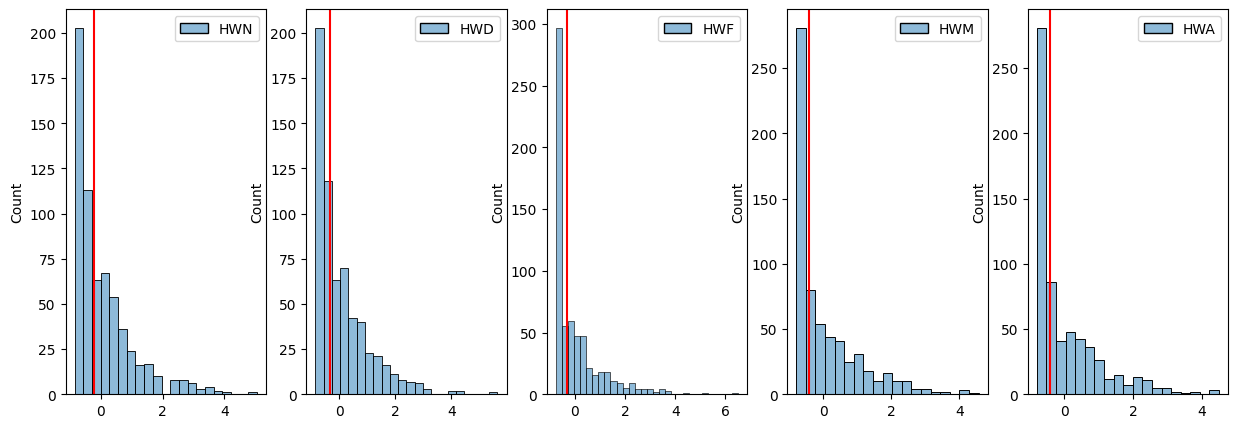

In [4]:
region = "chile"
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]

hws = read_hws(f"data/local_data/monthly/HWs_chile_central.csv")
scaler = StandardScaler()
hws[indices] = scaler.fit_transform(hws[indices])
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.histplot(hws[[index]], ax=axs[i])
    axs[i].axvline(np.median(hws[[index]]), color='red')

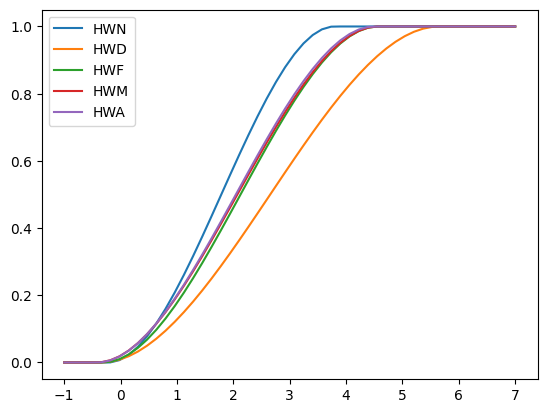

In [5]:
x = np.linspace(-1, 7)
relevance_index = {}
for index in indices:
    hws_index = hws[[index]].to_numpy()
    hws_index = hws_index.reshape(hws_index.shape[0])
    relevance = create_relevance_function(hws_index)
    relevance_index[index] = relevance
    plt.plot(x, relevance(x), label=index)
plt.legend()
plt.show()


# Ideas
- Study linear automatized vs paper automatized vs my automaziation
- Study the season distribution of each index:
    - Maybe the automatized way of the paper or linear 

## Season relevance function

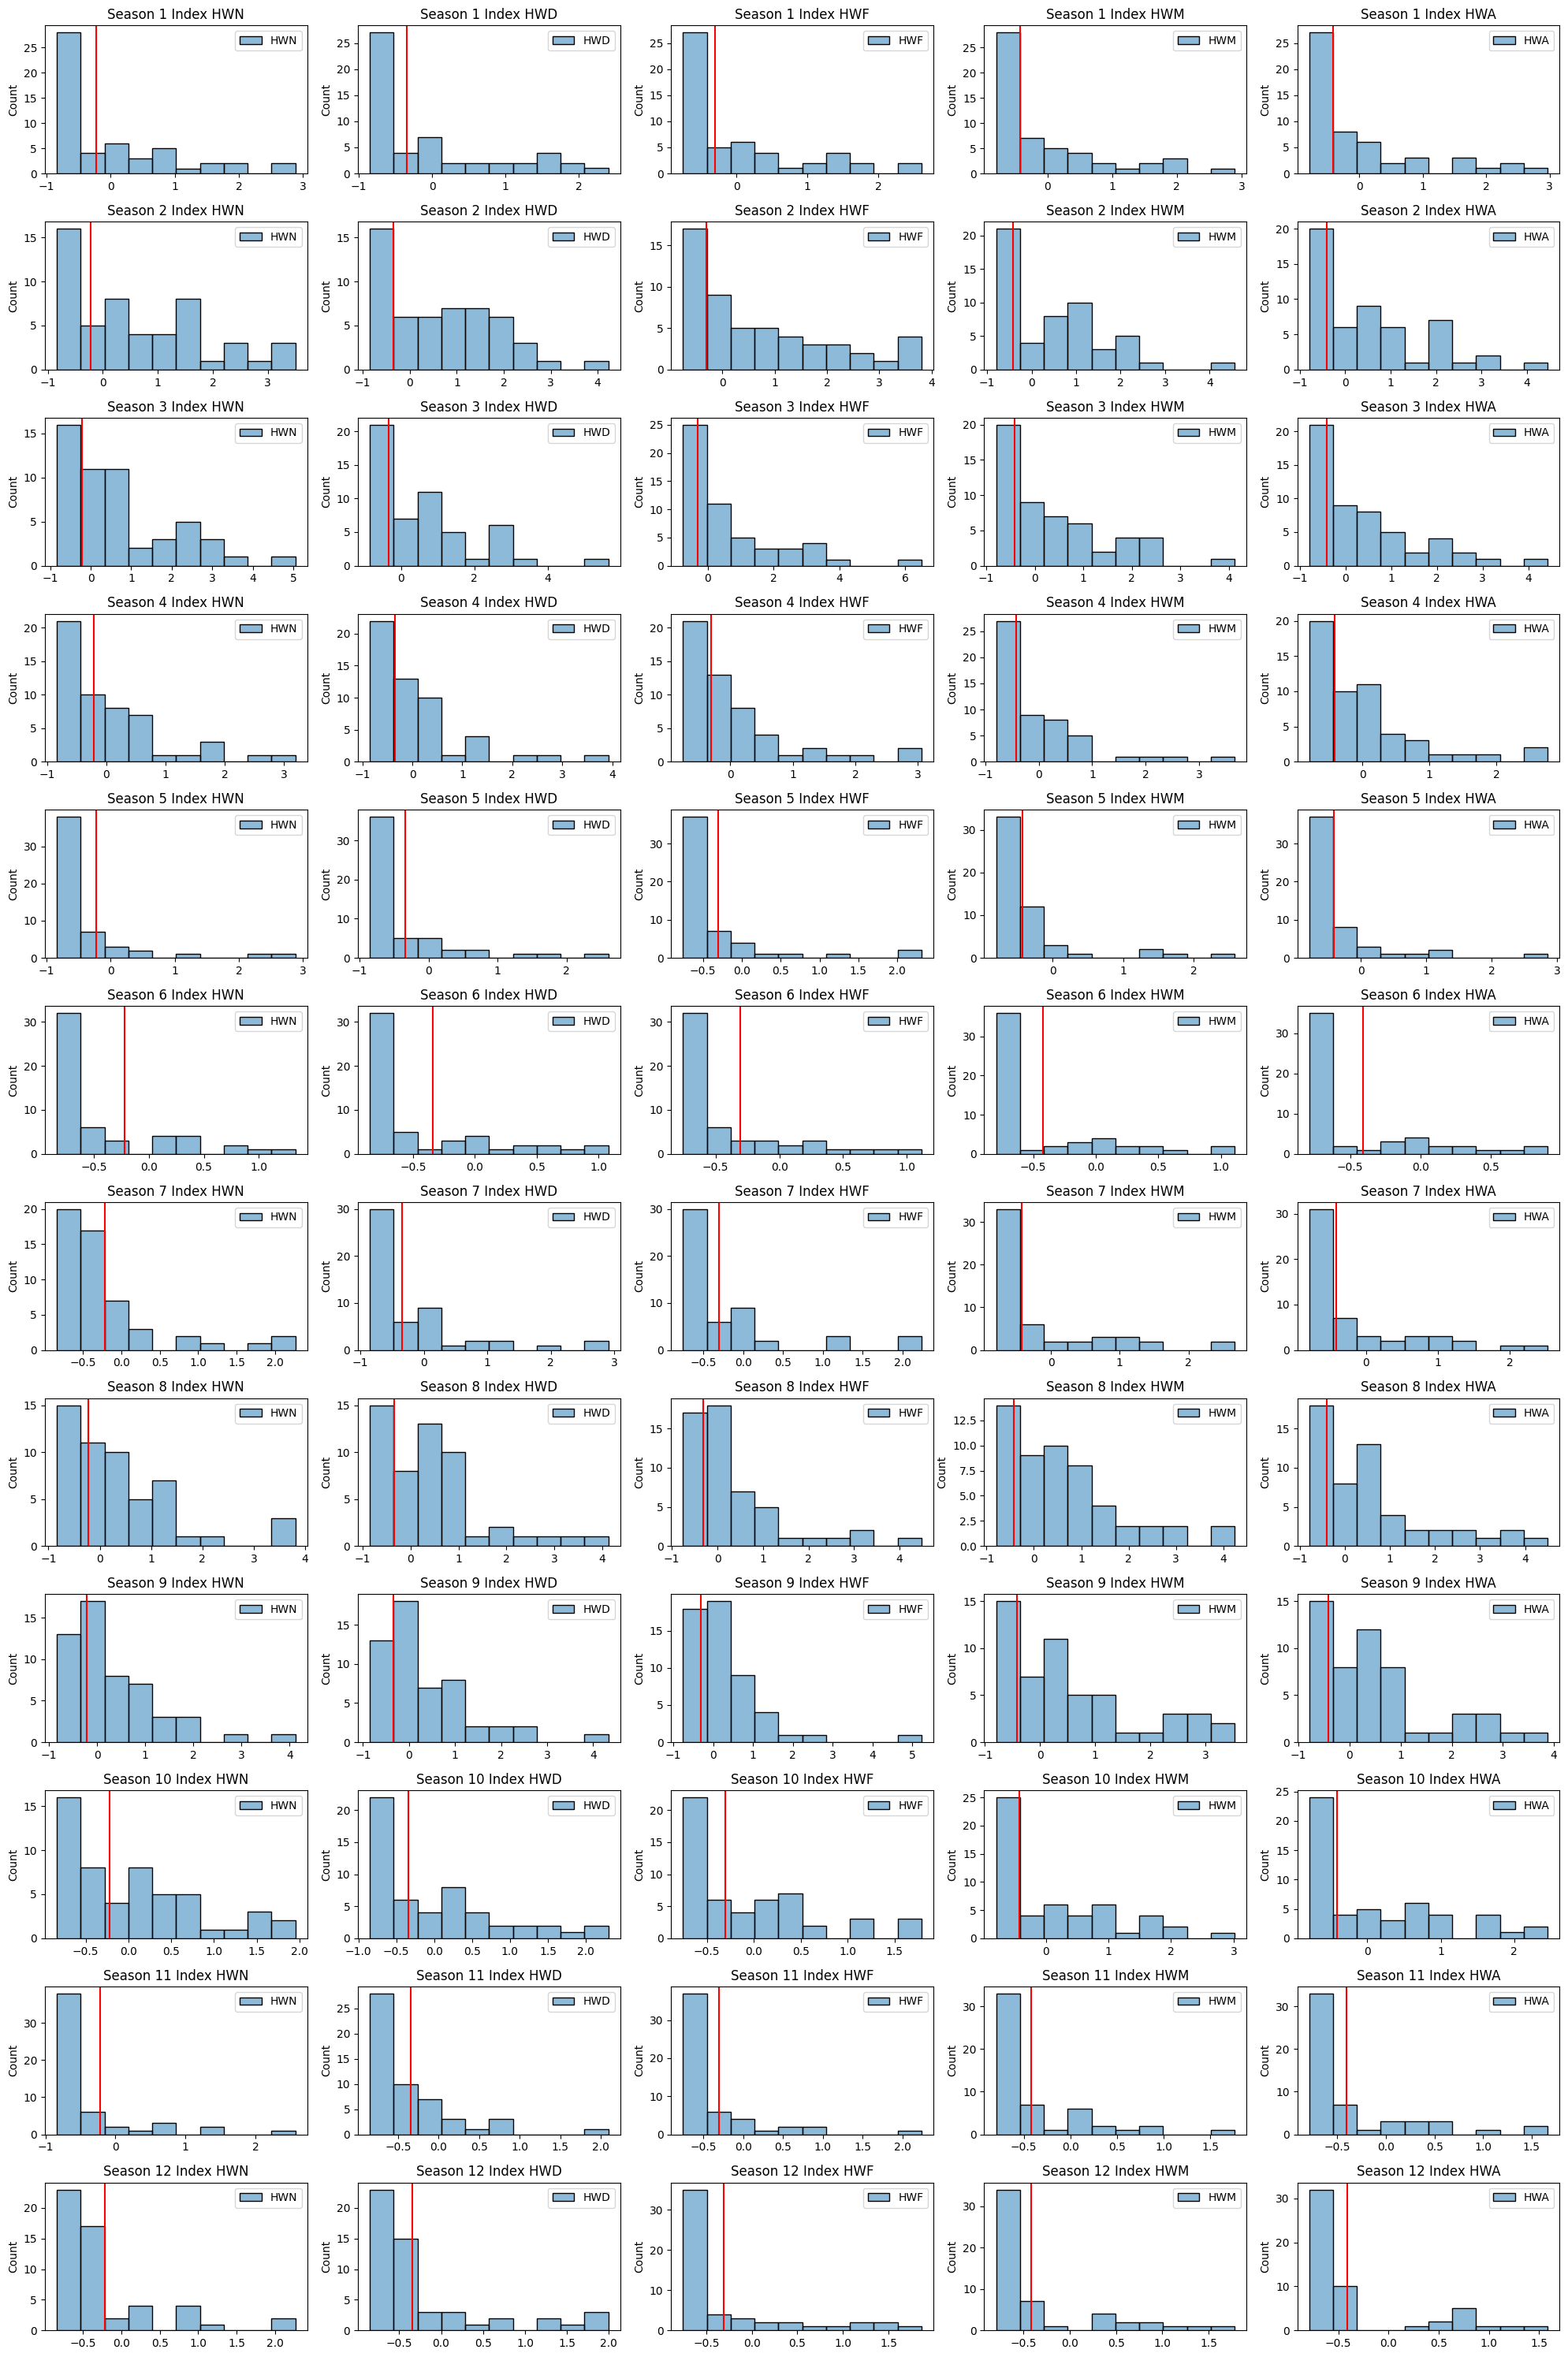

In [6]:
x = np.linspace(-1, 7)
relevance_index = {}
fig, axs = plt.subplots(12, 5, figsize=(20,30))
axs = axs.flatten()
for i in range(12):
    hws_month = hws[hws.index.month==i+1]
    for k, index in enumerate(indices):
        sns.histplot(hws_month[[index]], ax=axs[i*5+k], bins=10)
        axs[i*5+k].axvline(np.median(hws[[index]]), color='red')
        axs[i*5+k].set_title(f"Season {i+1} Index {index}")
plt.tight_layout()
plt.show()


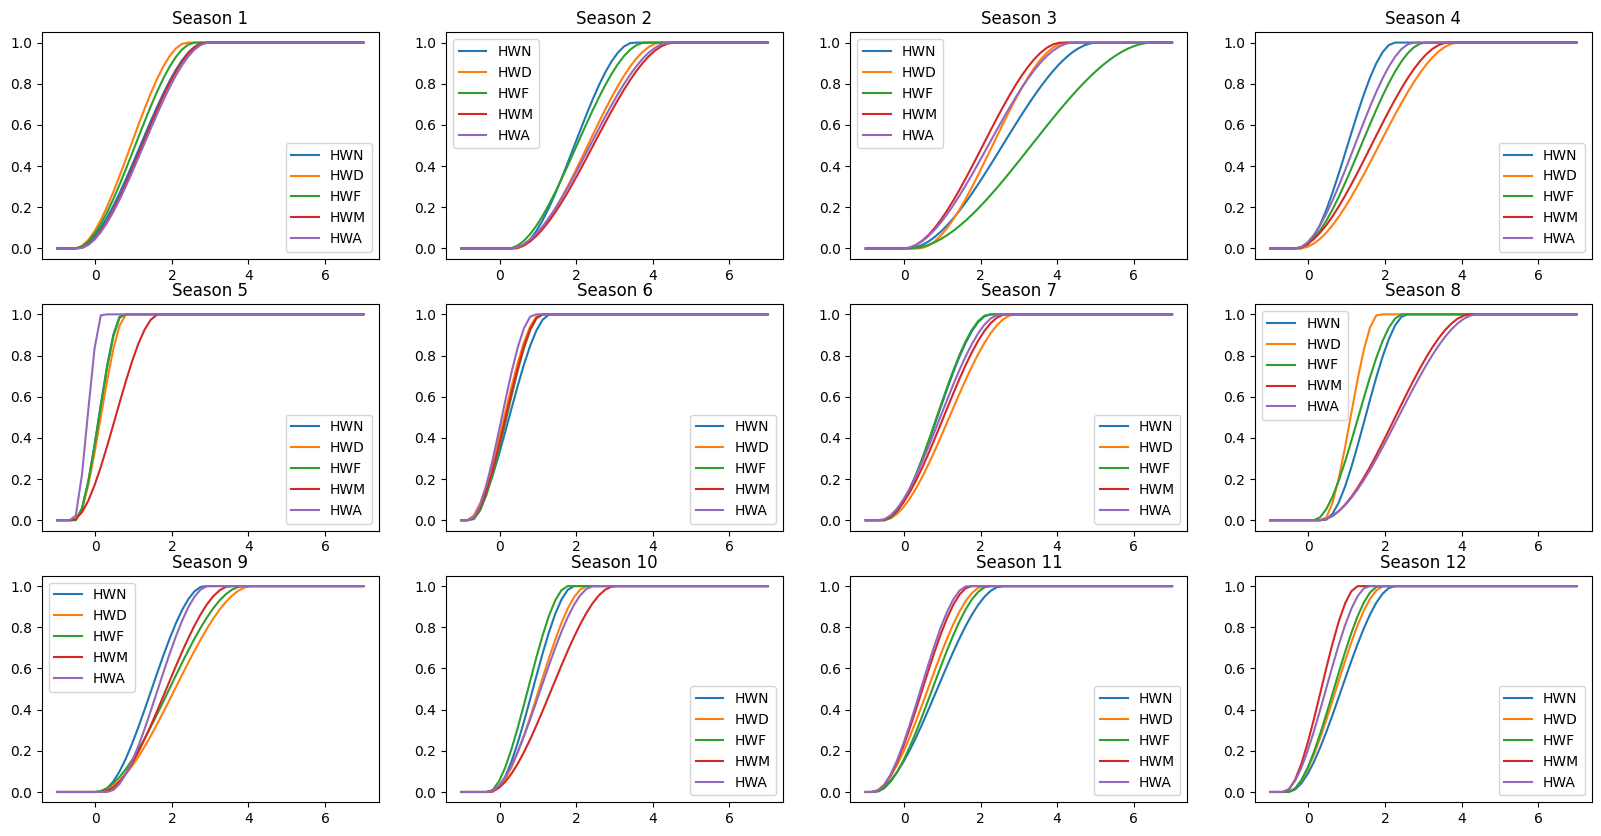

In [7]:
x = np.linspace(-1, 7)
relevance_index = {}
fig, axs = plt.subplots(3, 4, figsize=(20,10))
axs = axs.flatten()
for i in range(12):
    hws_month = hws[hws.index.month==i+1]
    for index in indices:
        hws_index = hws_month[[index]].to_numpy()
        hws_index = hws_index.reshape(hws_index.shape[0])
        relevance = create_relevance_function(hws_index)
        relevance_index[index] = relevance
        axs[i].plot(x, relevance(x), label=index)
    axs[i].legend()
    axs[i].set_title(f"Season {i+1}")
plt.show()


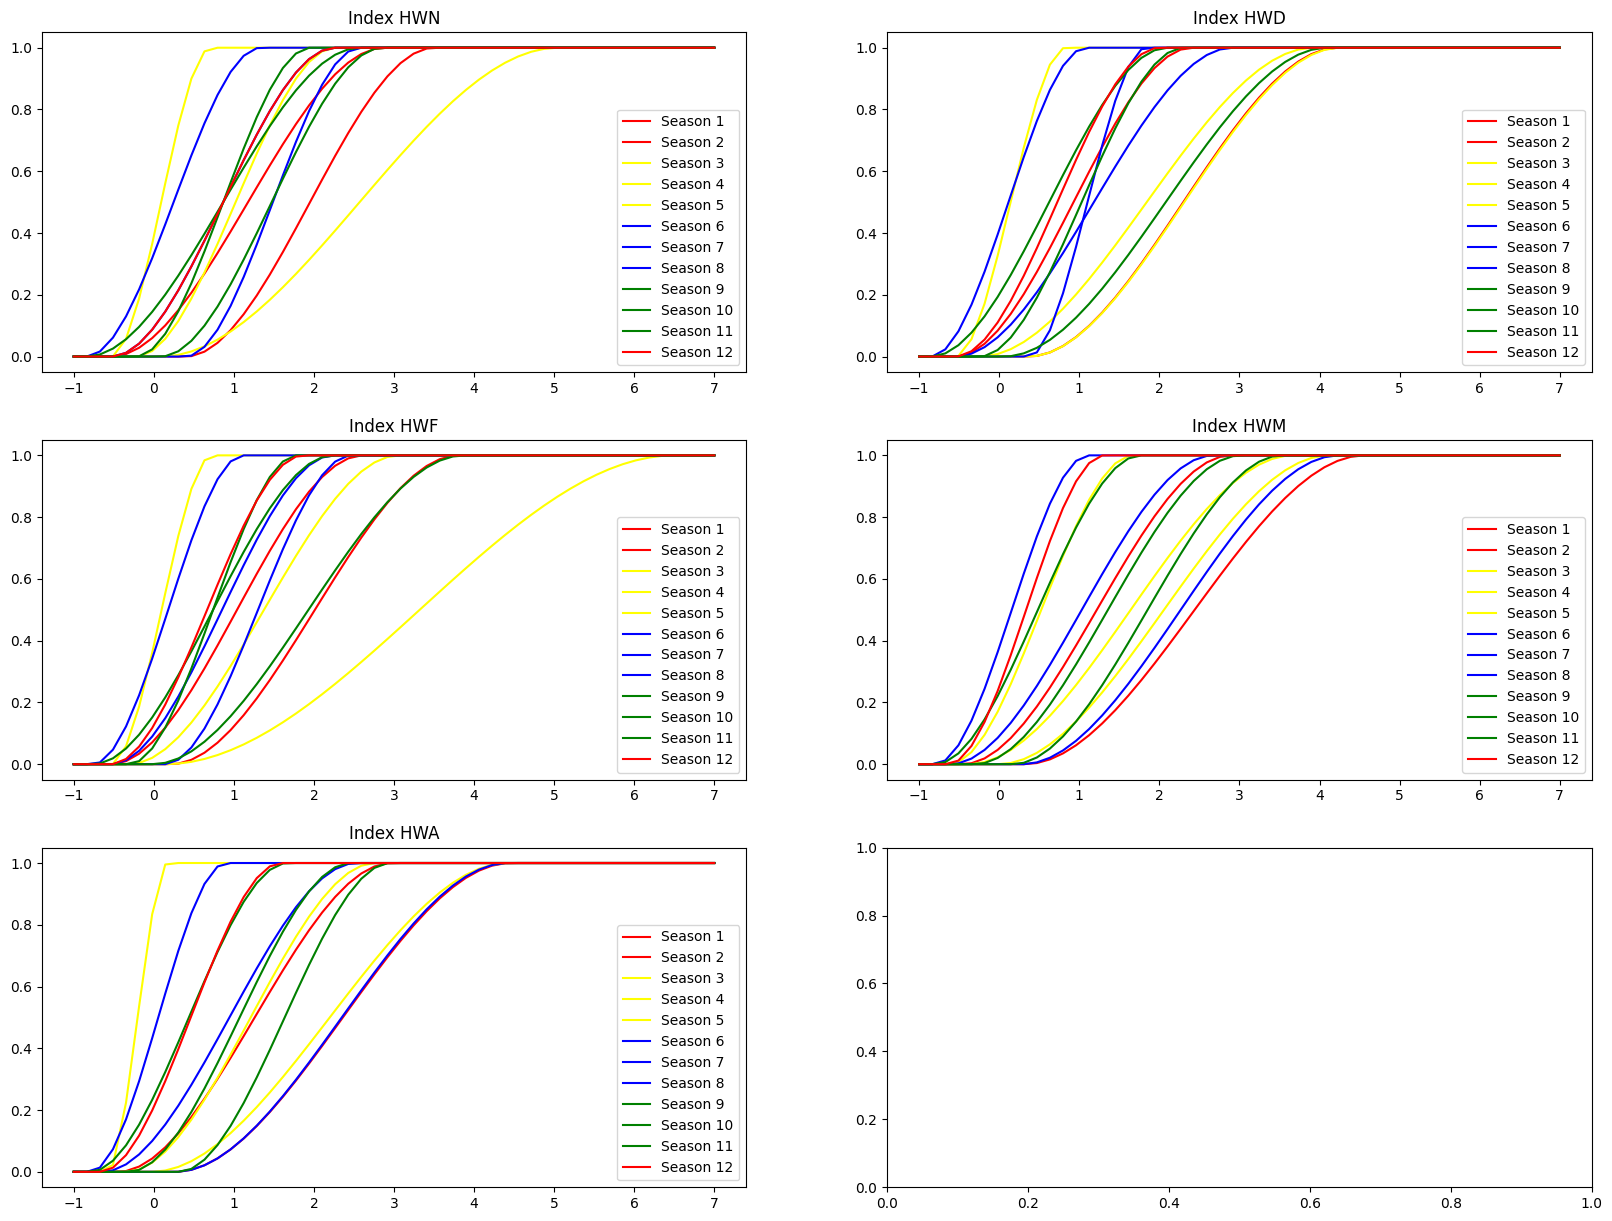

In [8]:
x = np.linspace(-1, 7)
relevance_index = {}
fig, axs = plt.subplots(3, 2, figsize=(20,15))
axs = axs.flatten()
colors = {
    1: "red",
    2: "red",
    3: "yellow",
    4: "yellow",
    5: "yellow",
    6: "blue",
    7: "blue",
    8: "blue",
    9: "green",
    10: "green",
    11: "green",
    12: "red"
}
for k, index in enumerate(indices):
    for i in range(12):
        hws_month = hws[hws.index.month==i+1]
        hws_index = hws_month[[index]].to_numpy()
        hws_index = hws_index.reshape(hws_index.shape[0])
        relevance = create_relevance_function(hws_index)
        relevance_index[index] = relevance
        axs[k].plot(x, relevance(x), label=f"Season {i+1}", c=colors[i+1])
    axs[k].legend()
    axs[k].set_title(f"Index {index}")
plt.show()


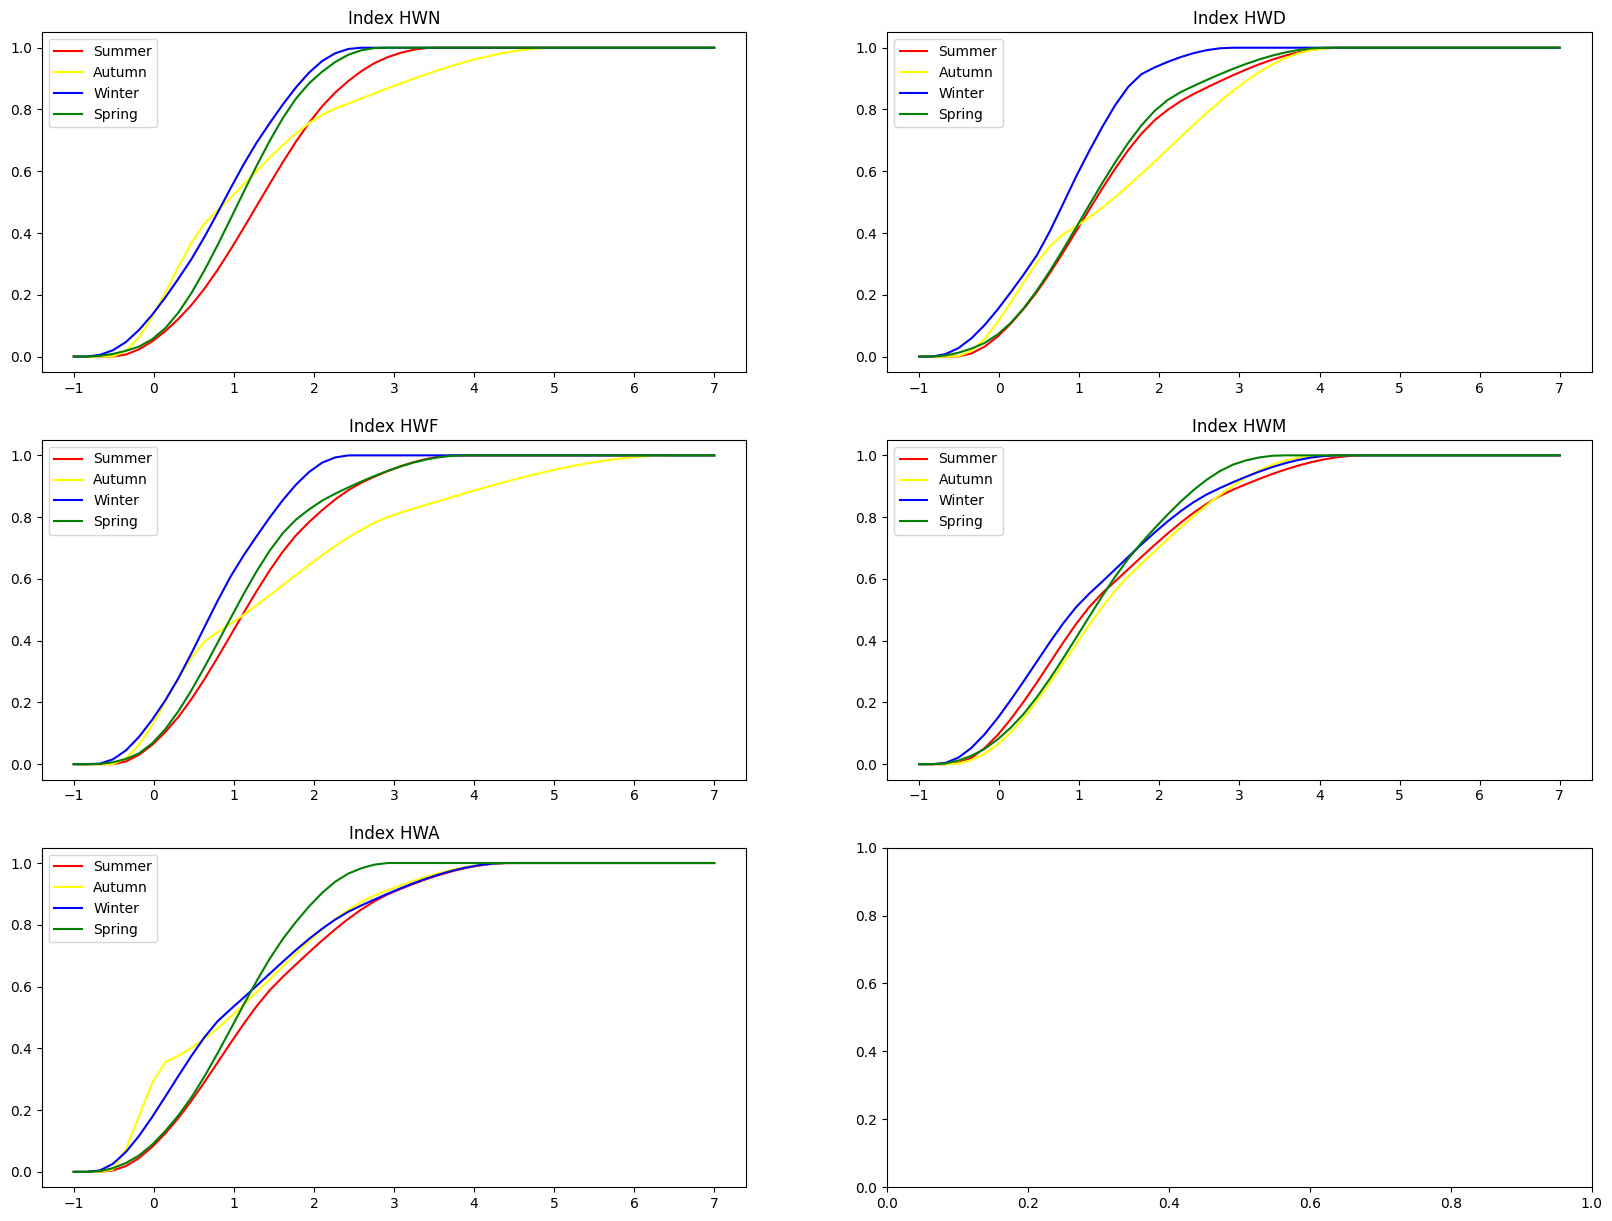

In [9]:
x = np.linspace(-1, 7)
fig, axs = plt.subplots(3, 2, figsize=(20,15))
axs = axs.flatten()
for k, index in enumerate(indices):
    relevance_index = {}
    for i in range(12):
        hws_month = hws[hws.index.month==i+1]
        hws_index = hws_month[[index]].to_numpy()
        hws_index = hws_index.reshape(hws_index.shape[0])
        relevance = create_relevance_function(hws_index)
        relevance_index[i+1] = relevance
    axs[k].plot(x, (relevance_index[1](x) + relevance_index[2](x) + relevance_index[12](x))/3, label=f"Summer", c="red")
    axs[k].plot(x, (relevance_index[3](x) + relevance_index[4](x) + relevance_index[5](x))/3, label=f"Autumn", c="yellow")
    axs[k].plot(x, (relevance_index[6](x) + relevance_index[7](x) + relevance_index[8](x))/3, label=f"Winter", c="blue")
    axs[k].plot(x, (relevance_index[9](x) + relevance_index[10](x) + relevance_index[11](x))/3, label=f"Spring", c="green")
    axs[k].legend()
    axs[k].set_title(f"Index {index}")
plt.show()


## Linear relevance function optimization

In [10]:
def linear_phi(y, bounds):
    x1, x2, x3, x4 = tf.unstack(bounds)
    # iqr = (x3-x2)
    # x1, x2, x3, x4, x5, x6, x7 = x1, x2, x2+iqr/4, x2+ iqr/2, x2 + iqr*0.75, x3, x4
    y1, y2, y3, y4 = 0.1, 0.1, 1, 1
    return tf.where(
        y <= x1, y1,
        tf.where(
            y <= x2,  y2 + (y2-y1)/(x2-x1)*(y-x2),
            tf.where(
                y <= x3, y3 + (y3-y2)/(x3-x2)*(y-x3),
                tf.where(
                    y <= x4, tf.ones_like(y), tf.ones_like(y)
                    )
                )
            )
        )

def compute_adjusted_boxplot_bounds(y):
    """
    Compute adjusted boxplot bounds using medcouple (MC) for skewness adjustment.
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    mc = medcouple(y)

    if mc >= 0:
        lower = q1 - 1.5 * np.exp(-4 * mc) * iqr
        upper = q3 + 1.5 * np.exp(3 * mc) * iqr
    else:
        lower = q1 - 1.5 * np.exp(-3 * mc) * iqr
        upper = q3 + 1.5 * np.exp(4 * mc) * iqr

    median = np.median(y)
    return lower, median, upper

class SERA(tf.keras.losses.Loss):
    def __init__(self, bounds, T=100, name="sera_loss"):
        super().__init__(name=name)
        self.bounds = tf.constant(bounds, dtype=tf.float32)
        self.T = T
        self.thresholds = tf.linspace(0.0, 1.0, T + 1)
        # self.relevance = relevance_fn

    def call(self, y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        errors = tf.square(y_pred - y_true)
        relevance = linear_phi(y_true, self.bounds)

        total = tf.constant(0.0, dtype=tf.float32)
        for i in range(self.T + 1):
            t = self.thresholds[i]
            mask = relevance >= t
            masked_errors = tf.boolean_mask(errors, mask)
            if tf.size(masked_errors) > 0:
                weight = 0.5 if (i == 0 or i == self.T) else 1.0
                total += weight * tf.reduce_sum(masked_errors)

        return total / tf.cast(self.T, tf.float32)

## First linear approximation to paper automatized

In [21]:
hws_index = hws[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = create_relevance_function(hws_index)

(-1.1692892810242344, -0.30647585455315646, 4.561547586528888, 6.499969486244418)


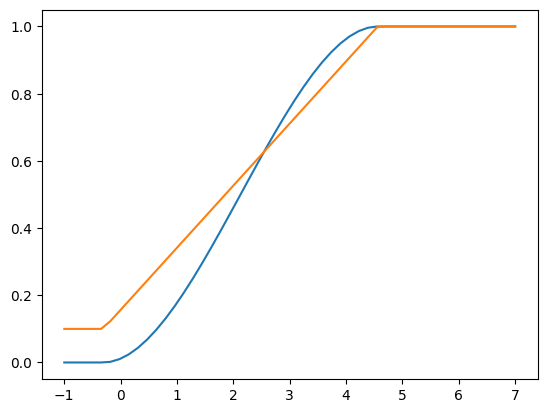

In [22]:
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, u, max(hws_index))
print(bounds)
f2 = linear_phi(hws_index, bounds)
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, linear_phi(x, bounds))

Epoch 1/200
6/6 [==============================] - 15s 595ms/step - loss: 19.3318 - mae: 0.8143 - val_loss: 15.9034 - val_mae: 0.9190
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 19.2510 - mae: 0.8178 - val_loss: 14.8160 - val_mae: 0.9208
Epoch 3/200
6/6 [==============================] - 0s 7ms/step - loss: 19.6210 - mae: 0.8129 - val_loss: 13.7765 - val_mae: 0.9252
Epoch 4/200
6/6 [==============================] - 0s 7ms/step - loss: 17.5374 - mae: 0.7962 - val_loss: 13.0109 - val_mae: 0.9300
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 18.4006 - mae: 0.8150 - val_loss: 12.3409 - val_mae: 0.9337
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 15.9619 - mae: 0.7927 - val_loss: 11.7014 - val_mae: 0.9367
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 17.6566 - mae: 0.8168 - val_loss: 11.1622 - val_mae: 0.9396
Epoch 8/200
6/6 [==============================] - 0s 7ms/step - loss: 15.9926 -

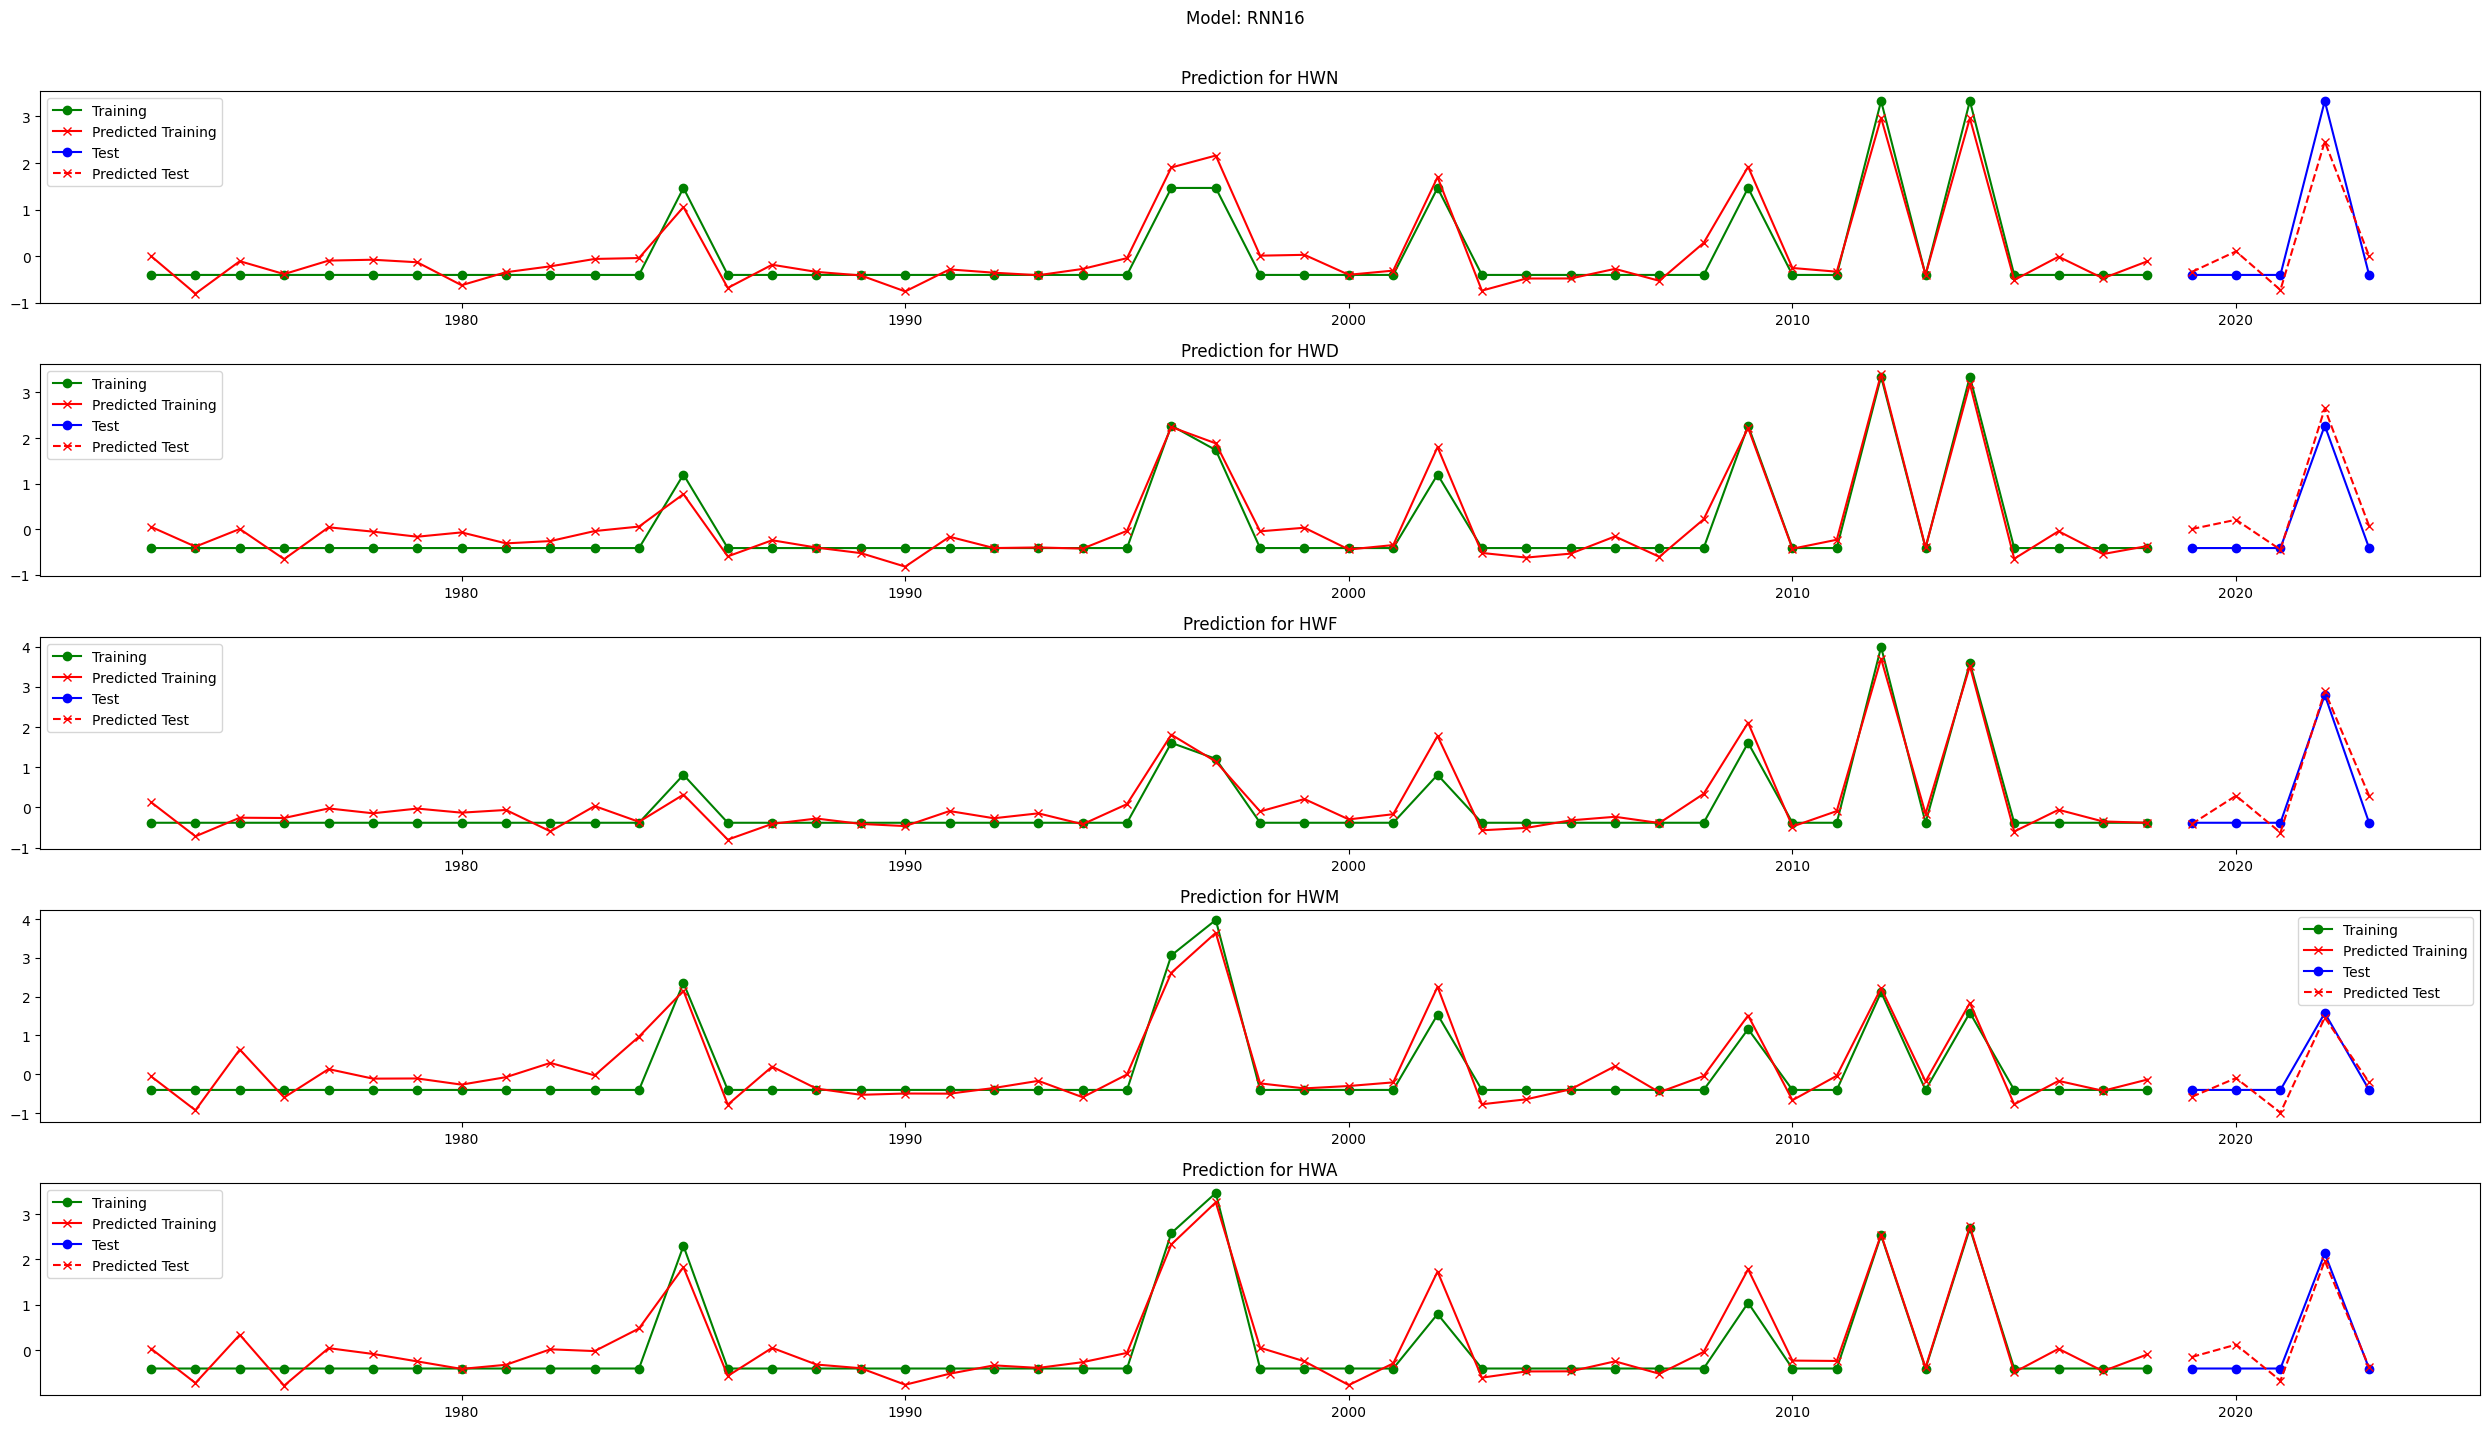

In [13]:
loss_fn = SERA(bounds=bounds,T=100)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 15s 679ms/step - loss: 13.3731 - mae: 1.0323 - val_loss: 4.2527 - val_mae: 0.6743
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 13.5889 - mae: 1.0103 - val_loss: 4.2396 - val_mae: 0.6753
Epoch 3/200
6/6 [==============================] - 0s 7ms/step - loss: 11.1878 - mae: 0.9802 - val_loss: 4.2107 - val_mae: 0.6756
Epoch 4/200
6/6 [==============================] - 0s 10ms/step - loss: 10.8648 - mae: 0.9468 - val_loss: 4.1796 - val_mae: 0.6760
Epoch 5/200
6/6 [==============================] - 0s 7ms/step - loss: 12.3039 - mae: 0.9748 - val_loss: 4.1436 - val_mae: 0.6762
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 11.3574 - mae: 0.9739 - val_loss: 4.1232 - val_mae: 0.6763
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 10.6452 - mae: 0.9544 - val_loss: 4.0855 - val_mae: 0.6759
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 11.3511 - mae: 

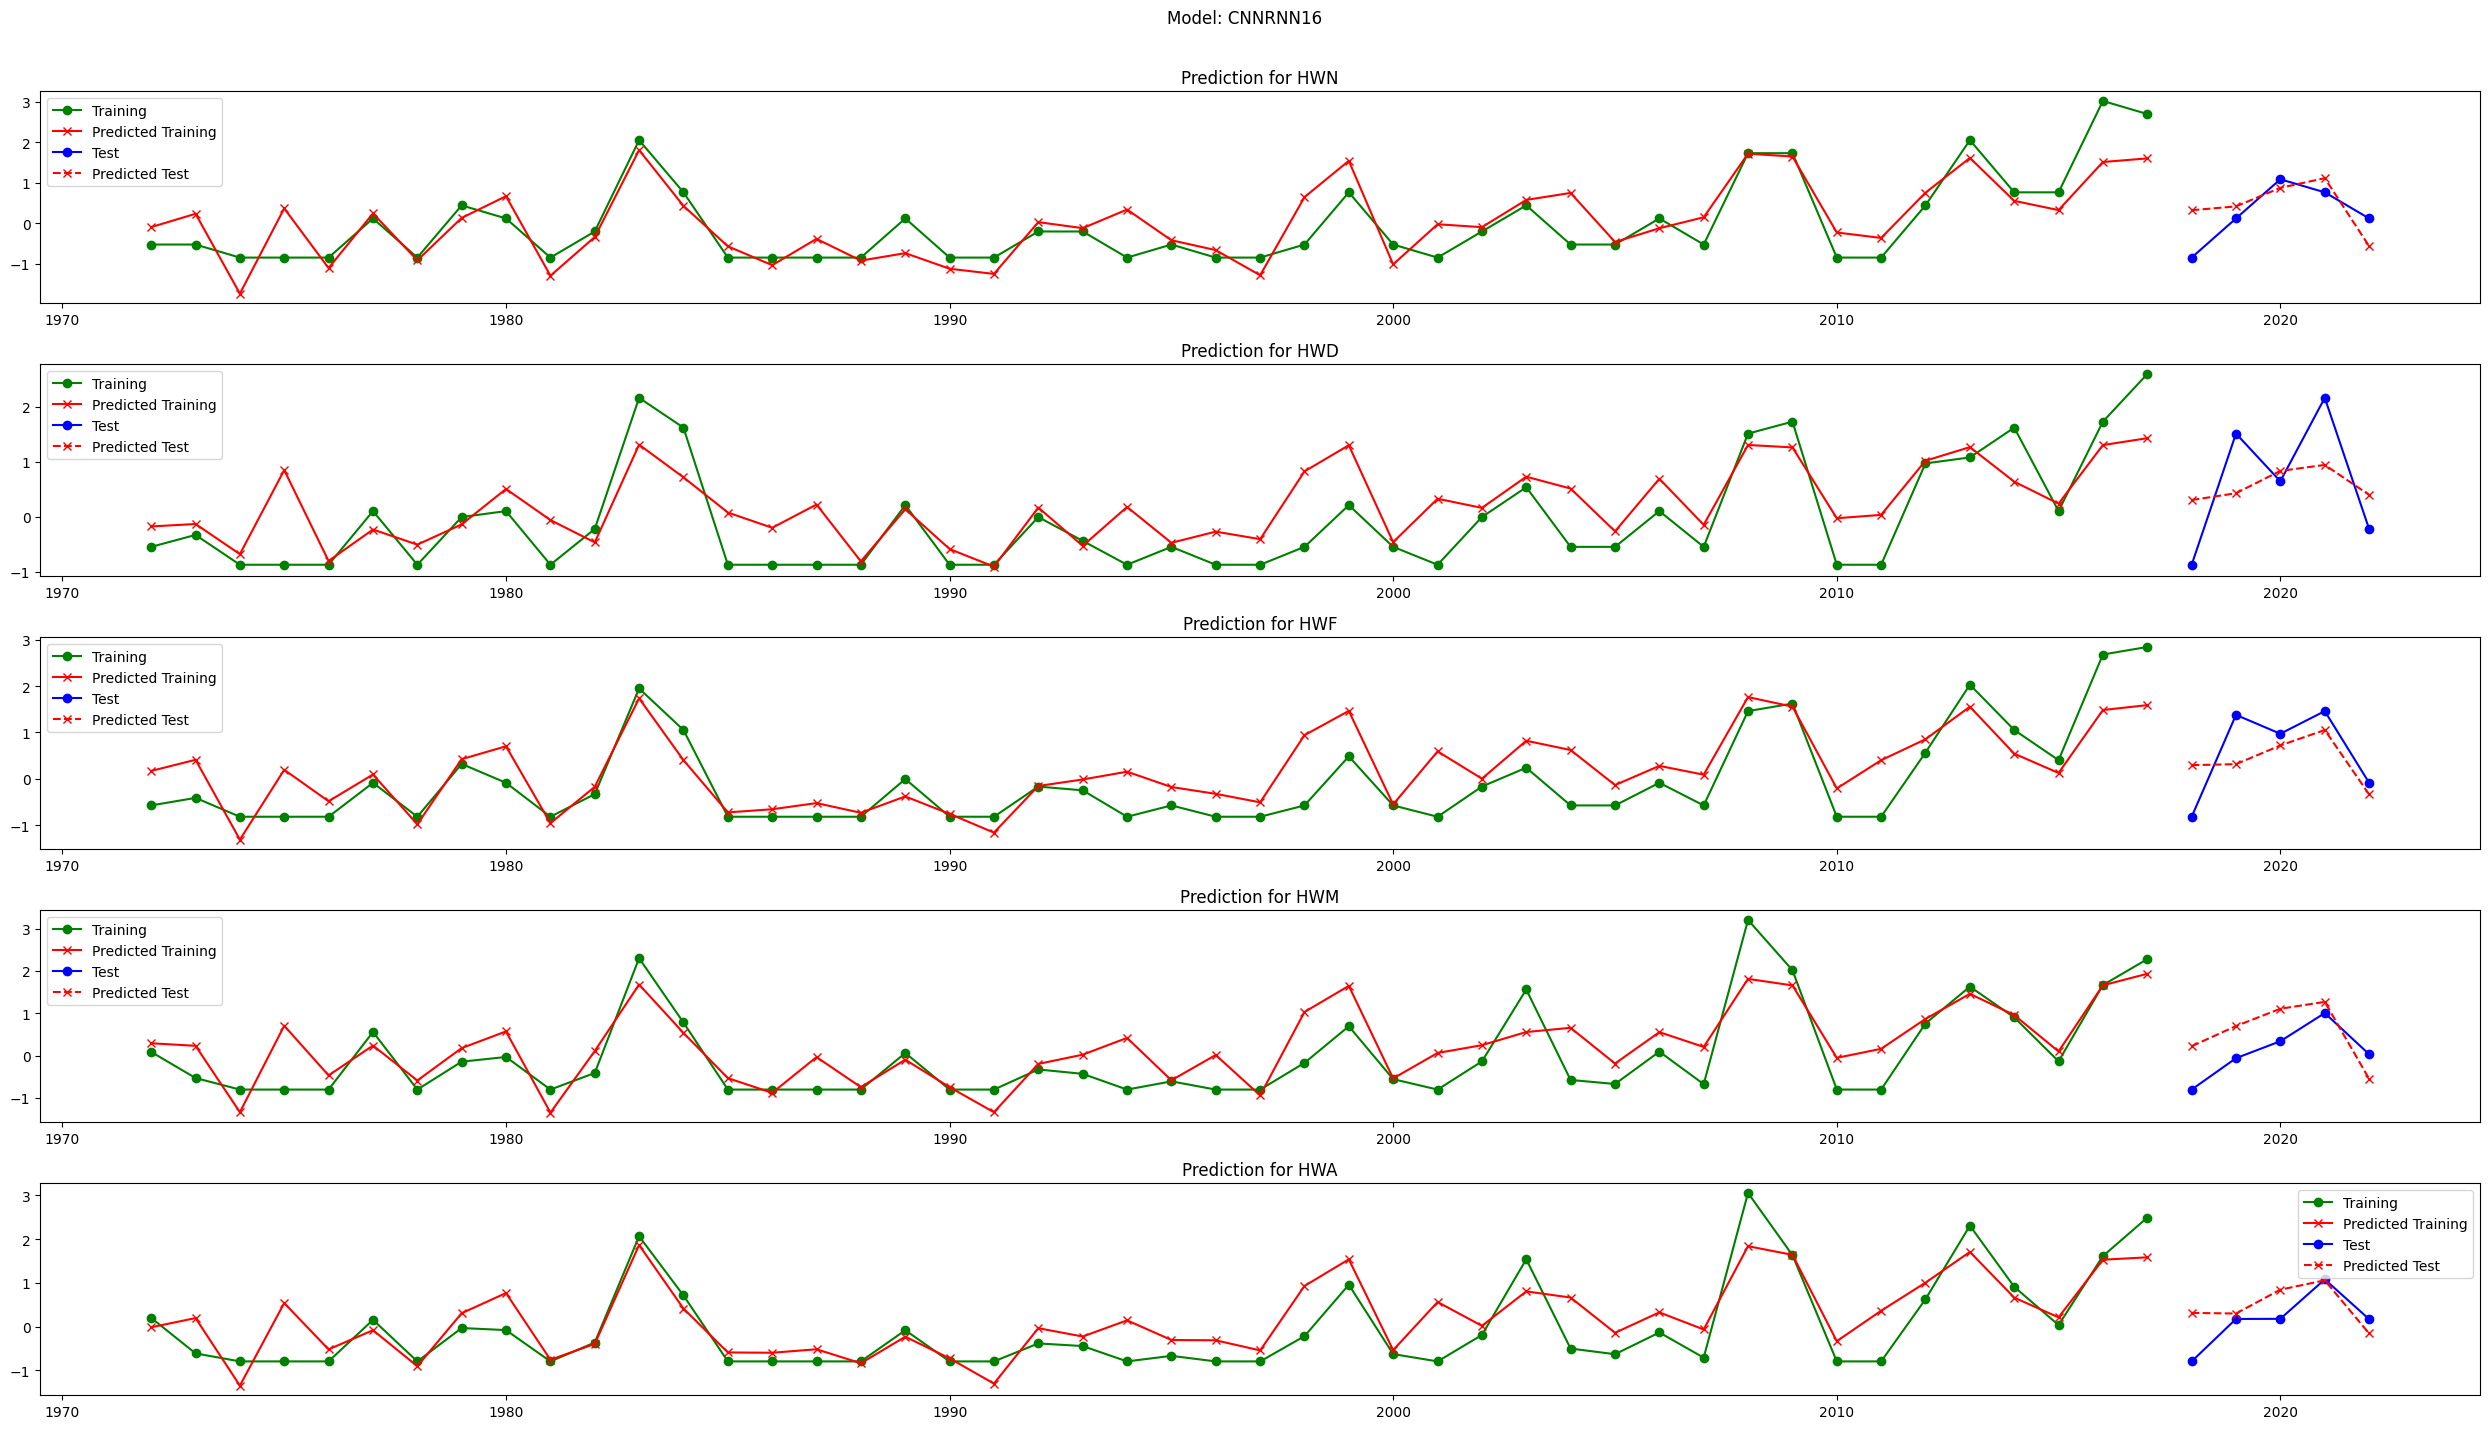

In [14]:
loss_fn = SERA(bounds=bounds,T=100)

id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 17s 742ms/step - loss: 13.5409 - mae: 0.7703 - val_loss: 93.5730 - val_mae: 1.2189
Epoch 2/200
6/6 [==============================] - 0s 12ms/step - loss: 16.3040 - mae: 0.7672 - val_loss: 93.6840 - val_mae: 1.1925
Epoch 3/200
6/6 [==============================] - 0s 11ms/step - loss: 15.0709 - mae: 0.7421 - val_loss: 93.5164 - val_mae: 1.1700
Epoch 4/200
6/6 [==============================] - 0s 12ms/step - loss: 15.4225 - mae: 0.7061 - val_loss: 93.3805 - val_mae: 1.1502
Epoch 5/200
6/6 [==============================] - 0s 11ms/step - loss: 14.5808 - mae: 0.7068 - val_loss: 93.2900 - val_mae: 1.1285
Epoch 6/200
6/6 [==============================] - 0s 10ms/step - loss: 14.6741 - mae: 0.6760 - val_loss: 93.0622 - val_mae: 1.1169
Epoch 7/200
6/6 [==============================] - 0s 11ms/step - loss: 14.6816 - mae: 0.6807 - val_loss: 92.7136 - val_mae: 1.1097
Epoch 8/200
6/6 [==============================] - 0s 10ms/step - loss: 14

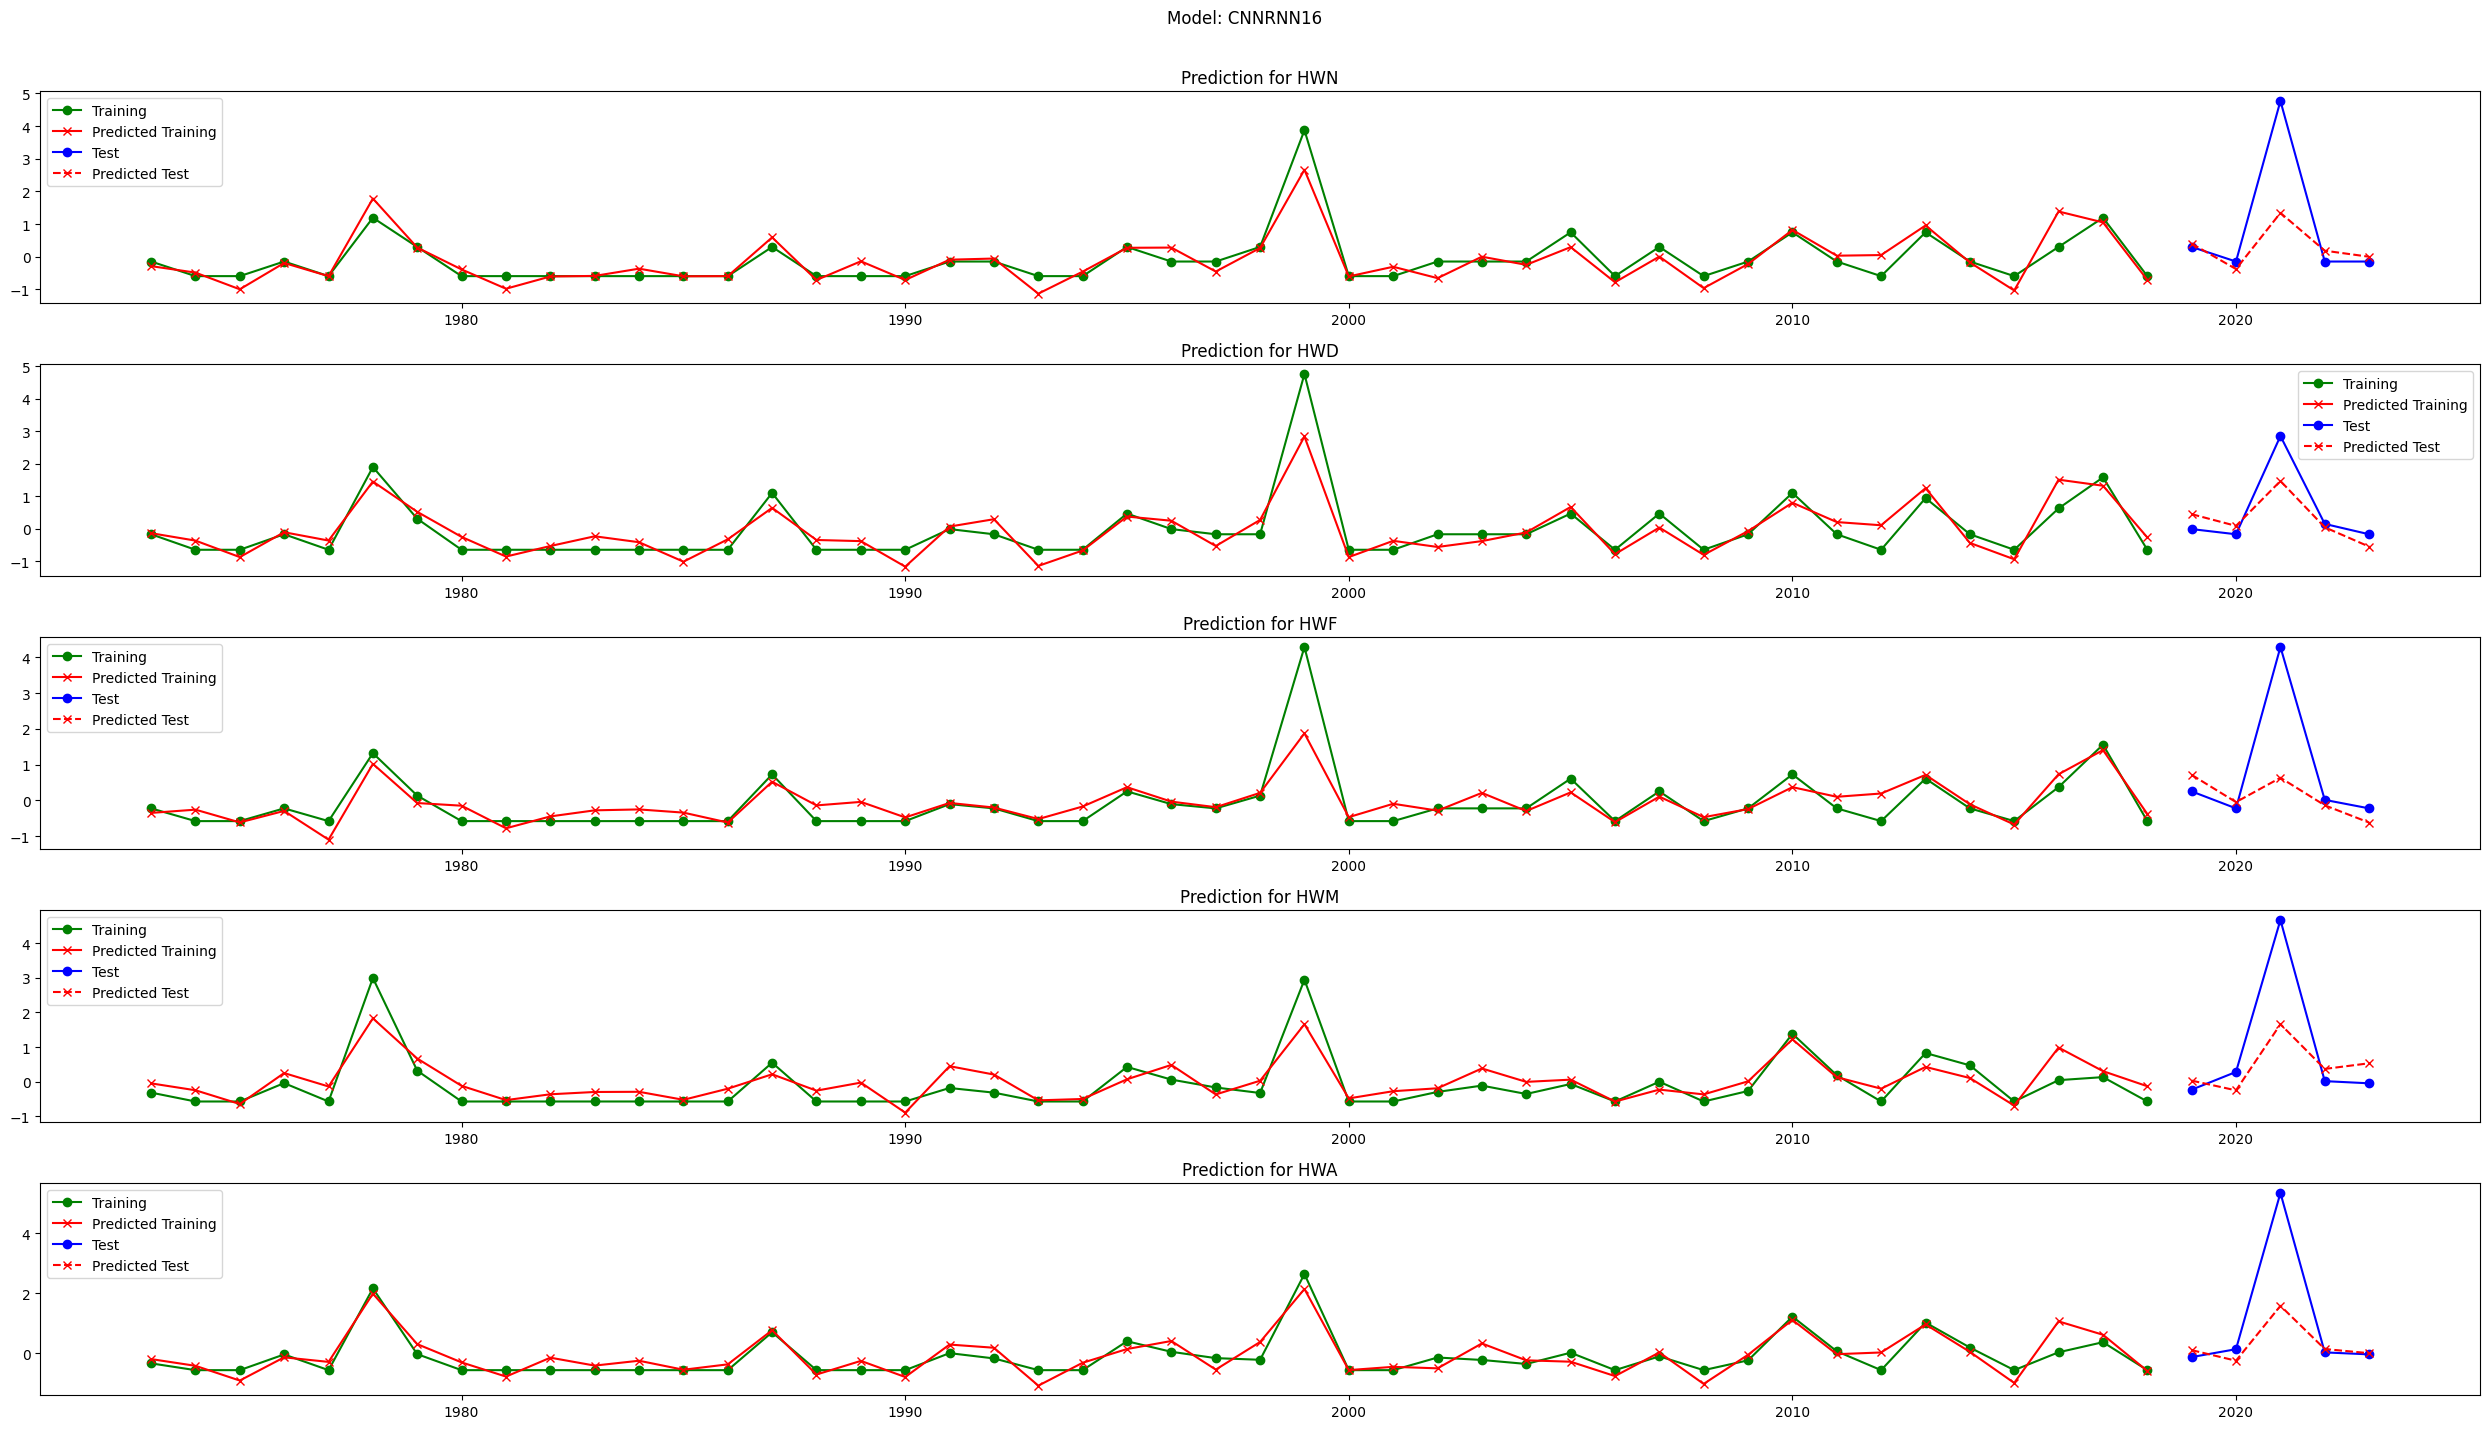

In [23]:
loss_fn = SERA(bounds=bounds,T=100)

id = "ecf2577f"
season = 5
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

## Season specific relevance fn opt

### January

In [ ]:
hws_jan = hws[hws.index.month==1]
hws_index = hws_jan[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = create_relevance_function(hws_index)

[-0.88172761 -0.53086416  2.61057215 12.09144245]


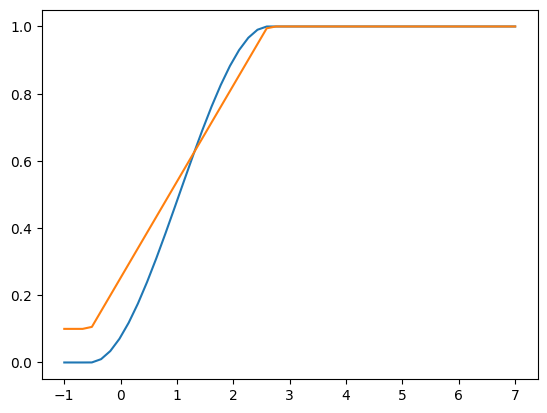

In [ ]:
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, u, max(hws_index))
bounds = np.sort(bounds)
print(bounds)
f2 = linear_phi(hws_index, bounds)
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, linear_phi(x, bounds))

Epoch 1/200
6/6 [==============================] - 16s 645ms/step - loss: 29.7766 - mae: 0.8941 - val_loss: 8.4184 - val_mae: 0.7407
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 28.1787 - mae: 0.8970 - val_loss: 8.2763 - val_mae: 0.7424
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 24.2537 - mae: 0.8891 - val_loss: 8.1178 - val_mae: 0.7434
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 24.5322 - mae: 0.8547 - val_loss: 7.9673 - val_mae: 0.7450
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 24.6426 - mae: 0.8778 - val_loss: 7.8416 - val_mae: 0.7450
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 22.2113 - mae: 0.8769 - val_loss: 7.7441 - val_mae: 0.7454
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 22.3336 - mae: 0.8999 - val_loss: 7.6385 - val_mae: 0.7451
Epoch 8/200
6/6 [==============================] - 0s 11ms/step - loss: 25.1030 - mae: 

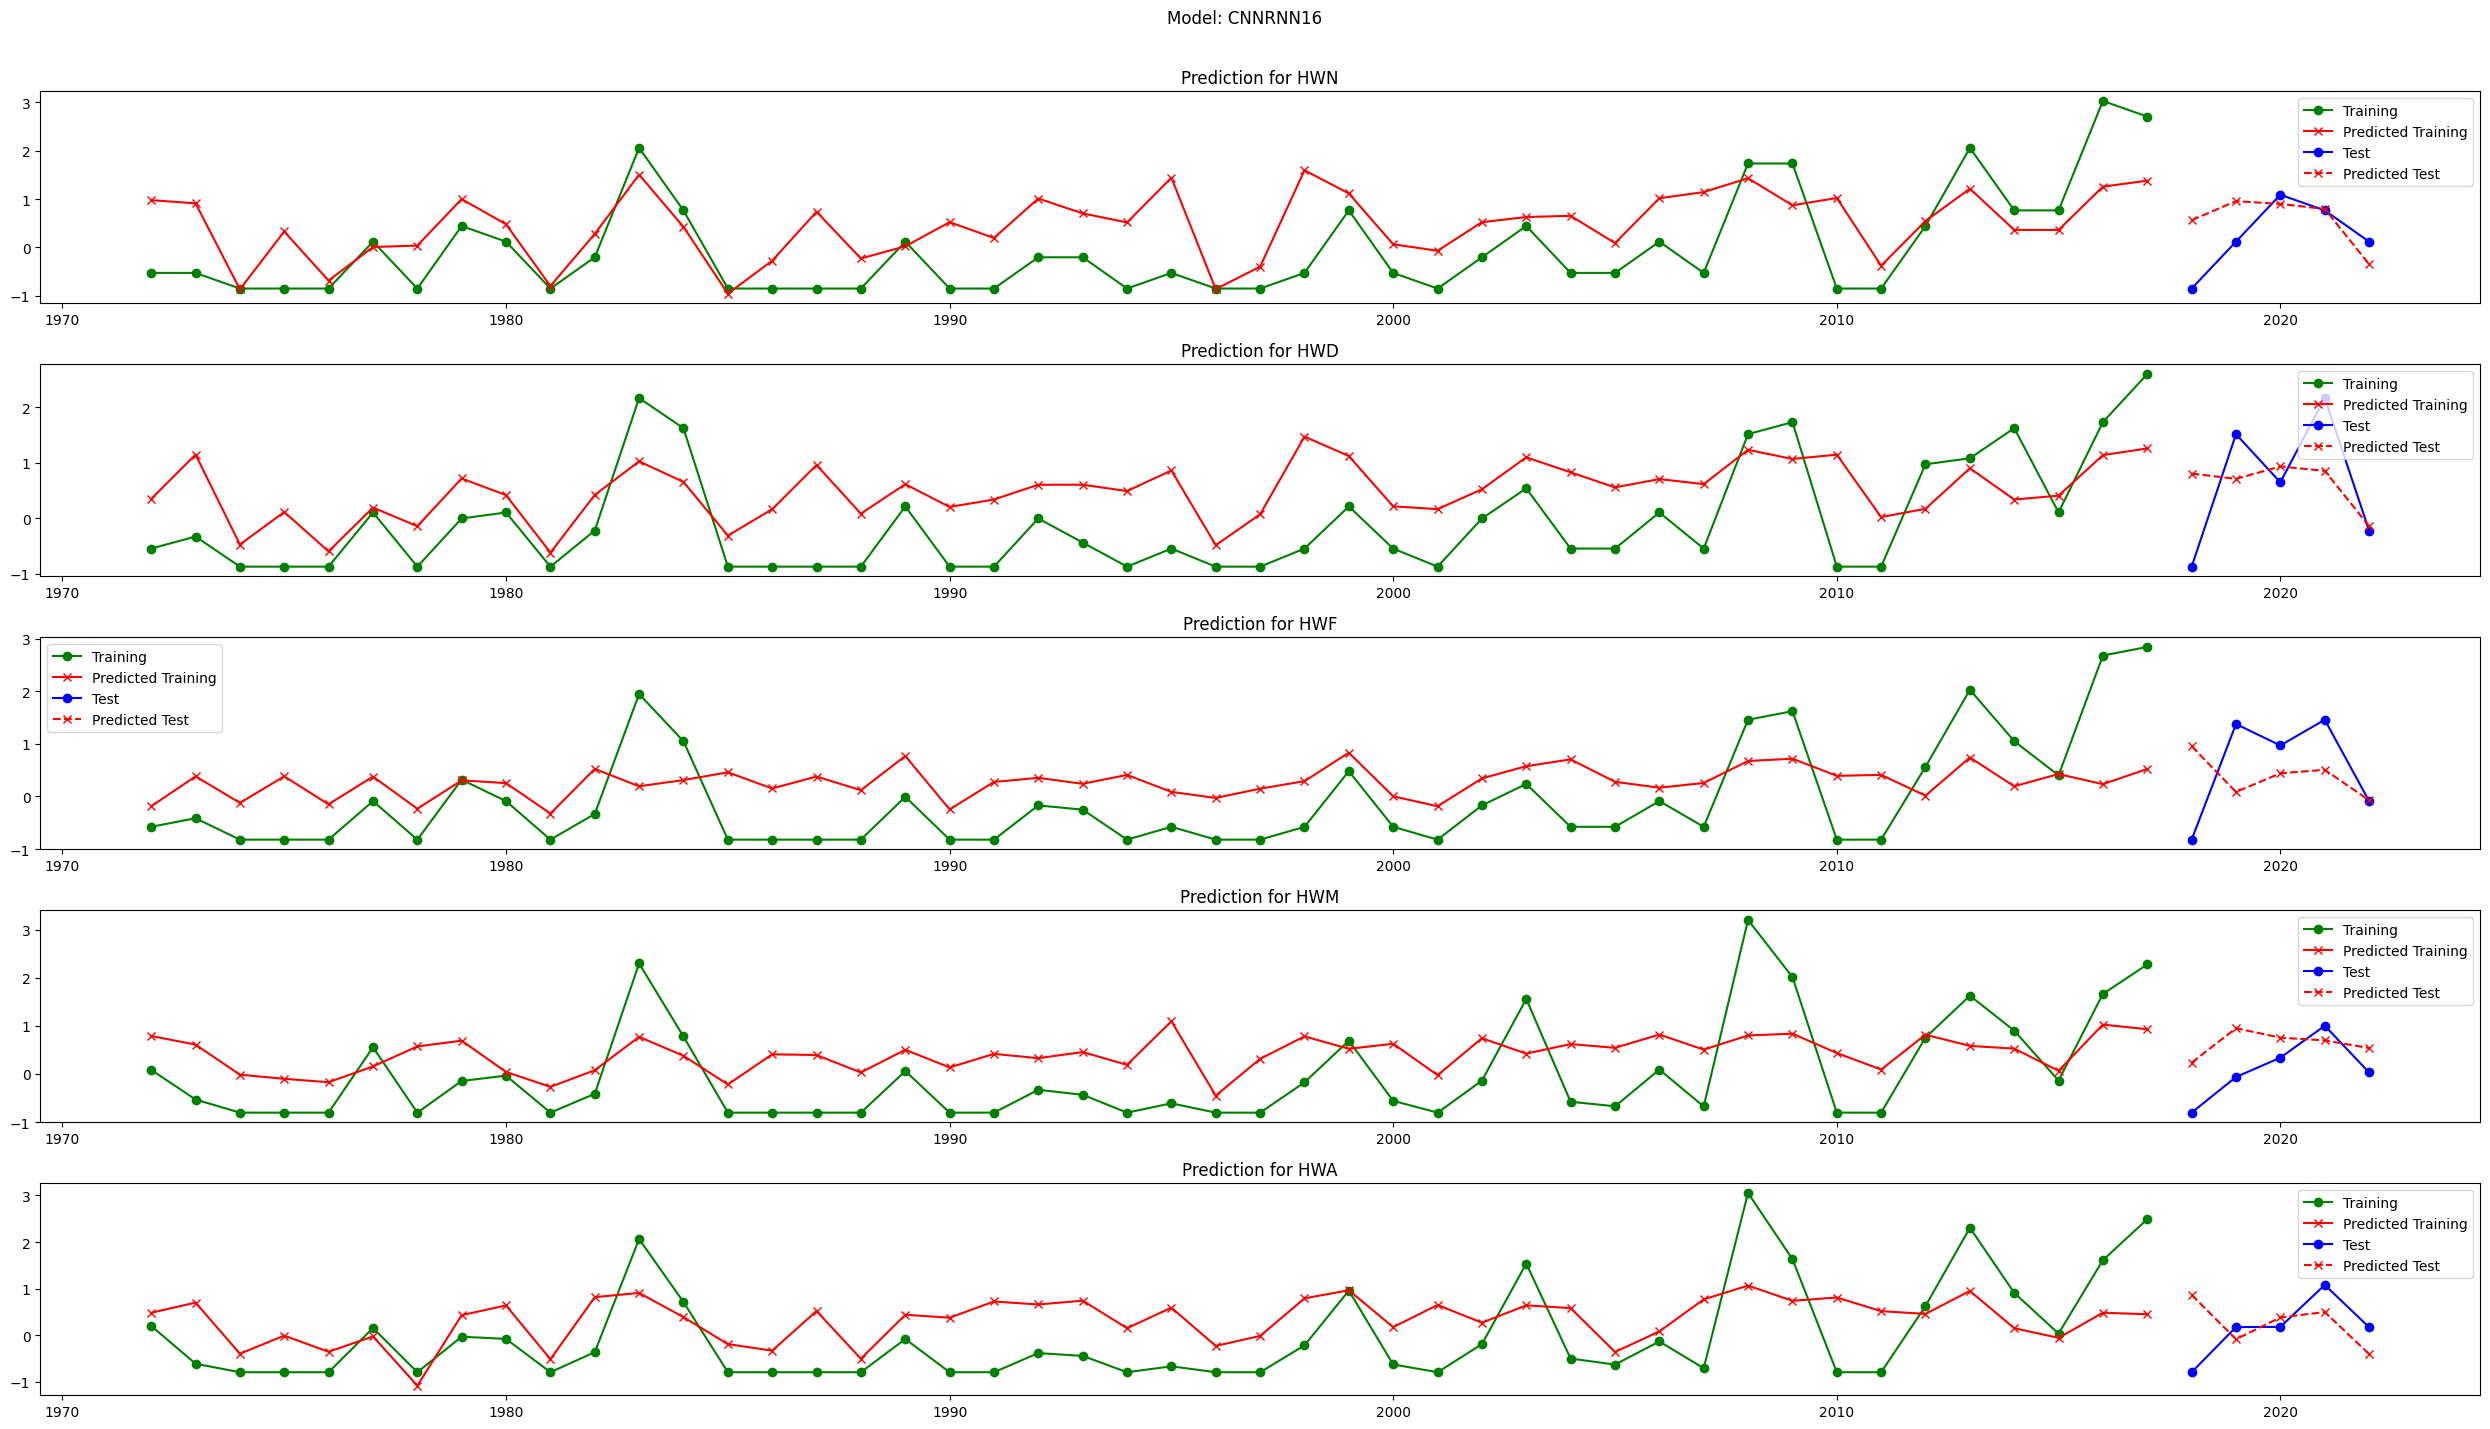

In [ ]:
loss_fn = SERA(bounds=bounds,T=100)

id = "d7101242"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

### December

In [ ]:
hws_dec = hws[hws.index.month==12]
hws_index = hws_dec[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = create_relevance_function(hws_index)

[-0.89190692 -0.53086416  1.86261112  4.44328628]


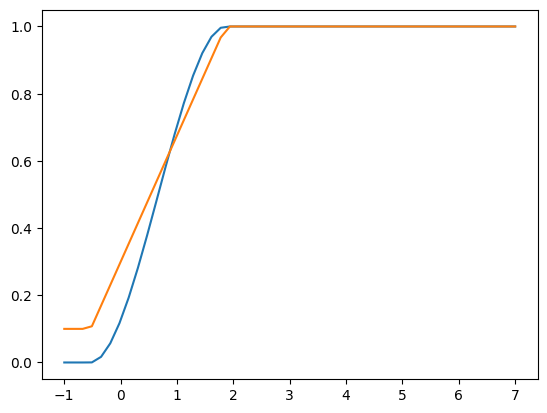

In [ ]:
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, u, max(hws_index))
bounds = np.sort(bounds)
print(bounds)
f2 = linear_phi(hws_index, bounds)
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, linear_phi(x, bounds))

Epoch 1/200
6/6 [==============================] - 17s 703ms/step - loss: 34.0718 - mae: 0.7782 - val_loss: 34.9636 - val_mae: 0.9784
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 32.1729 - mae: 0.7620 - val_loss: 33.7597 - val_mae: 0.9754
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 32.2172 - mae: 0.7618 - val_loss: 32.6793 - val_mae: 0.9733
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 29.4599 - mae: 0.7192 - val_loss: 31.6002 - val_mae: 0.9693
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 30.5943 - mae: 0.7585 - val_loss: 30.6855 - val_mae: 0.9653
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 28.9781 - mae: 0.7633 - val_loss: 29.9026 - val_mae: 0.9613
Epoch 7/200
6/6 [==============================] - 0s 7ms/step - loss: 28.5400 - mae: 0.7341 - val_loss: 29.1781 - val_mae: 0.9582
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 27.4220 -

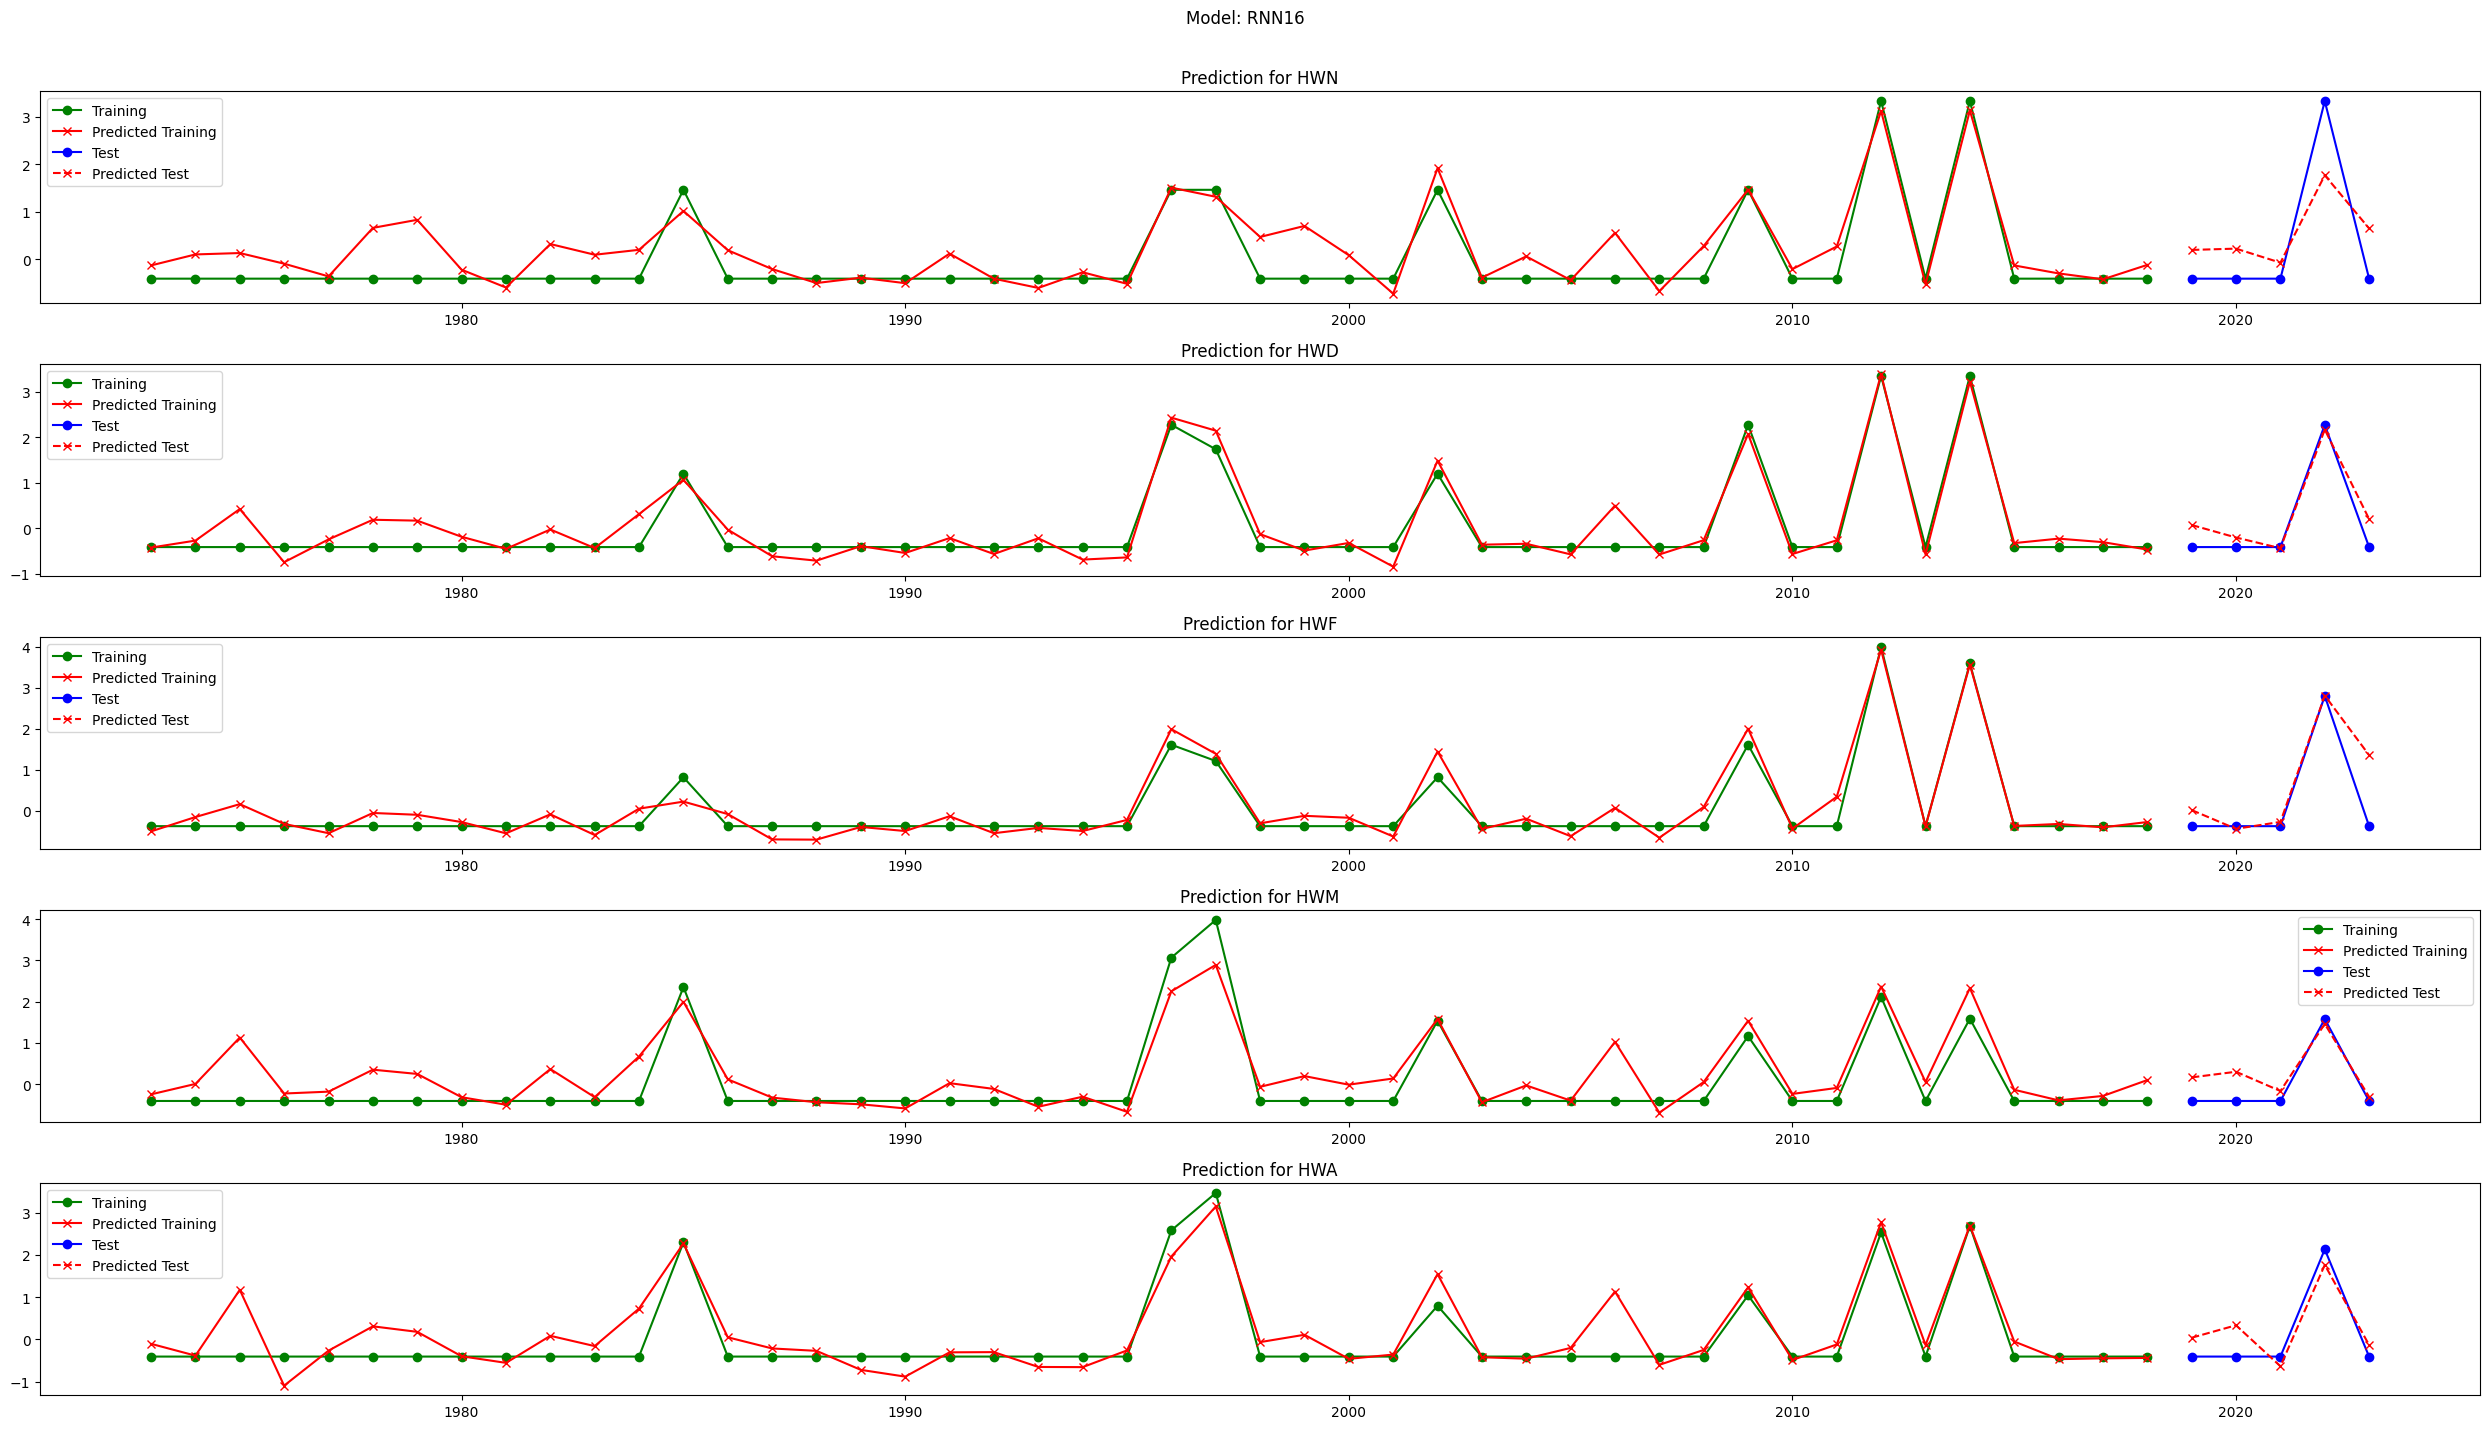

In [ ]:
loss_fn = SERA(bounds=bounds,T=100)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

## Linear approx try on adjusting initial weight

In [31]:
def linear_phi_2(bounds, initial_weight=0.3):
    x1, x2, x3, x4 = tf.unstack(bounds)
    # iqr = (x3-x2)
    # x1, x2, x3, x4, x5, x6, x7 = x1, x2, x2+iqr/4, x2+ iqr/2, x2 + iqr*0.75, x3, x4
    y1, y2, y3, y4 = initial_weight, initial_weight, 1, 1
    return lambda y: tf.where(
        y <= x1, y1,
        tf.where(
            y <= x2,  y2 + (y2-y1)/(x2-x1)*(y-x2),
            tf.where(
                y <= x3, y3 + (y3-y2)/(x3-x2)*(y-x3),
                tf.where(
                    y <= x4, tf.ones_like(y), tf.ones_like(y)
                    )
                )
            )
        )

class SERA(tf.keras.losses.Loss):
    def __init__(self, bounds, T=100, name="sera_loss", initial_weight=0.3):
        super().__init__(name=name)
        self.bounds = tf.constant(bounds, dtype=tf.float32)
        self.T = T
        self.initial_w = initial_weight
        self.thresholds = tf.linspace(0.0, 1.0, T + 1)
        # self.relevance = relevance_fn

    def call(self, y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        errors = tf.square(y_pred - y_true)
        relevance = linear_phi_2(self.bounds, initial_weight=self.initial_w)(y_true)

        total = tf.constant(0.0, dtype=tf.float32)
        for i in range(self.T + 1):
            t = self.thresholds[i]
            mask = relevance >= t
            masked_errors = tf.boolean_mask(errors, mask)
            if tf.size(masked_errors) > 0:
                weight = 0.5 if (i == 0 or i == self.T) else 1.0
                total += weight * tf.reduce_sum(masked_errors)

        return total / tf.cast(self.T, tf.float32)

In [32]:
hws_index = hws[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = create_relevance_function(hws_index)

(-1.1692892810242344, -0.30647585455315646, 3, 6.499969486244418)


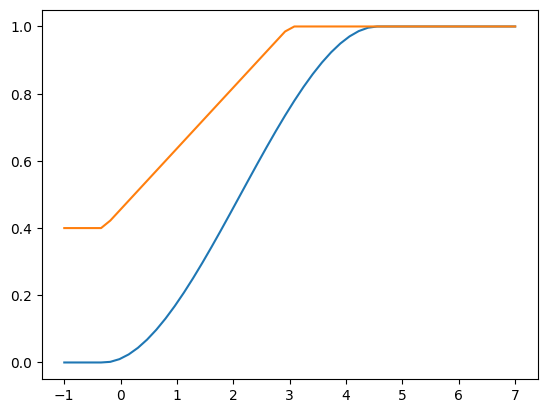

In [34]:
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, 3, max(hws_index))
print(bounds)
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, linear_phi_2(bounds, initial_weight=0.4)(x))

In [35]:
def compute_sera(y_true, y_pred, relevance_fn, step=0.01):
    """
    Compute SERA metric given true values, predictions, and a relevance function φ(y).
    """
    t_values = np.arange(0, 1 + step, step)
    ser_t = []

    for t in t_values:
        indices = [i for i, y in enumerate(y_true) if relevance_fn(y) >= t]
        if len(indices) == 0:
            ser_t.append(0.0)
            continue
        squared_errors = [(y_pred[i] - y_true[i]) ** 2 for i in indices]
        ser_t.append(np.sum(squared_errors))

    sera_score = np.trapz(ser_t, t_values)
    return sera_score, t_values, ser_t

Epoch 1/200
6/6 [==============================] - 16s 640ms/step - loss: 31.6324 - mae: 0.8031 - val_loss: 30.1672 - val_mae: 0.8957
Epoch 2/200
6/6 [==============================] - 0s 13ms/step - loss: 31.5751 - mae: 0.8066 - val_loss: 28.3806 - val_mae: 0.8900
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 29.9792 - mae: 0.7780 - val_loss: 27.2624 - val_mae: 0.8903
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 27.0518 - mae: 0.7279 - val_loss: 26.3359 - val_mae: 0.8898
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 27.7028 - mae: 0.7479 - val_loss: 25.5698 - val_mae: 0.8893
Epoch 6/200
6/6 [==============================] - 0s 10ms/step - loss: 25.7418 - mae: 0.7256 - val_loss: 24.8456 - val_mae: 0.8879
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 24.9411 - mae: 0.7196 - val_loss: 24.2240 - val_mae: 0.8868
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 25.7199

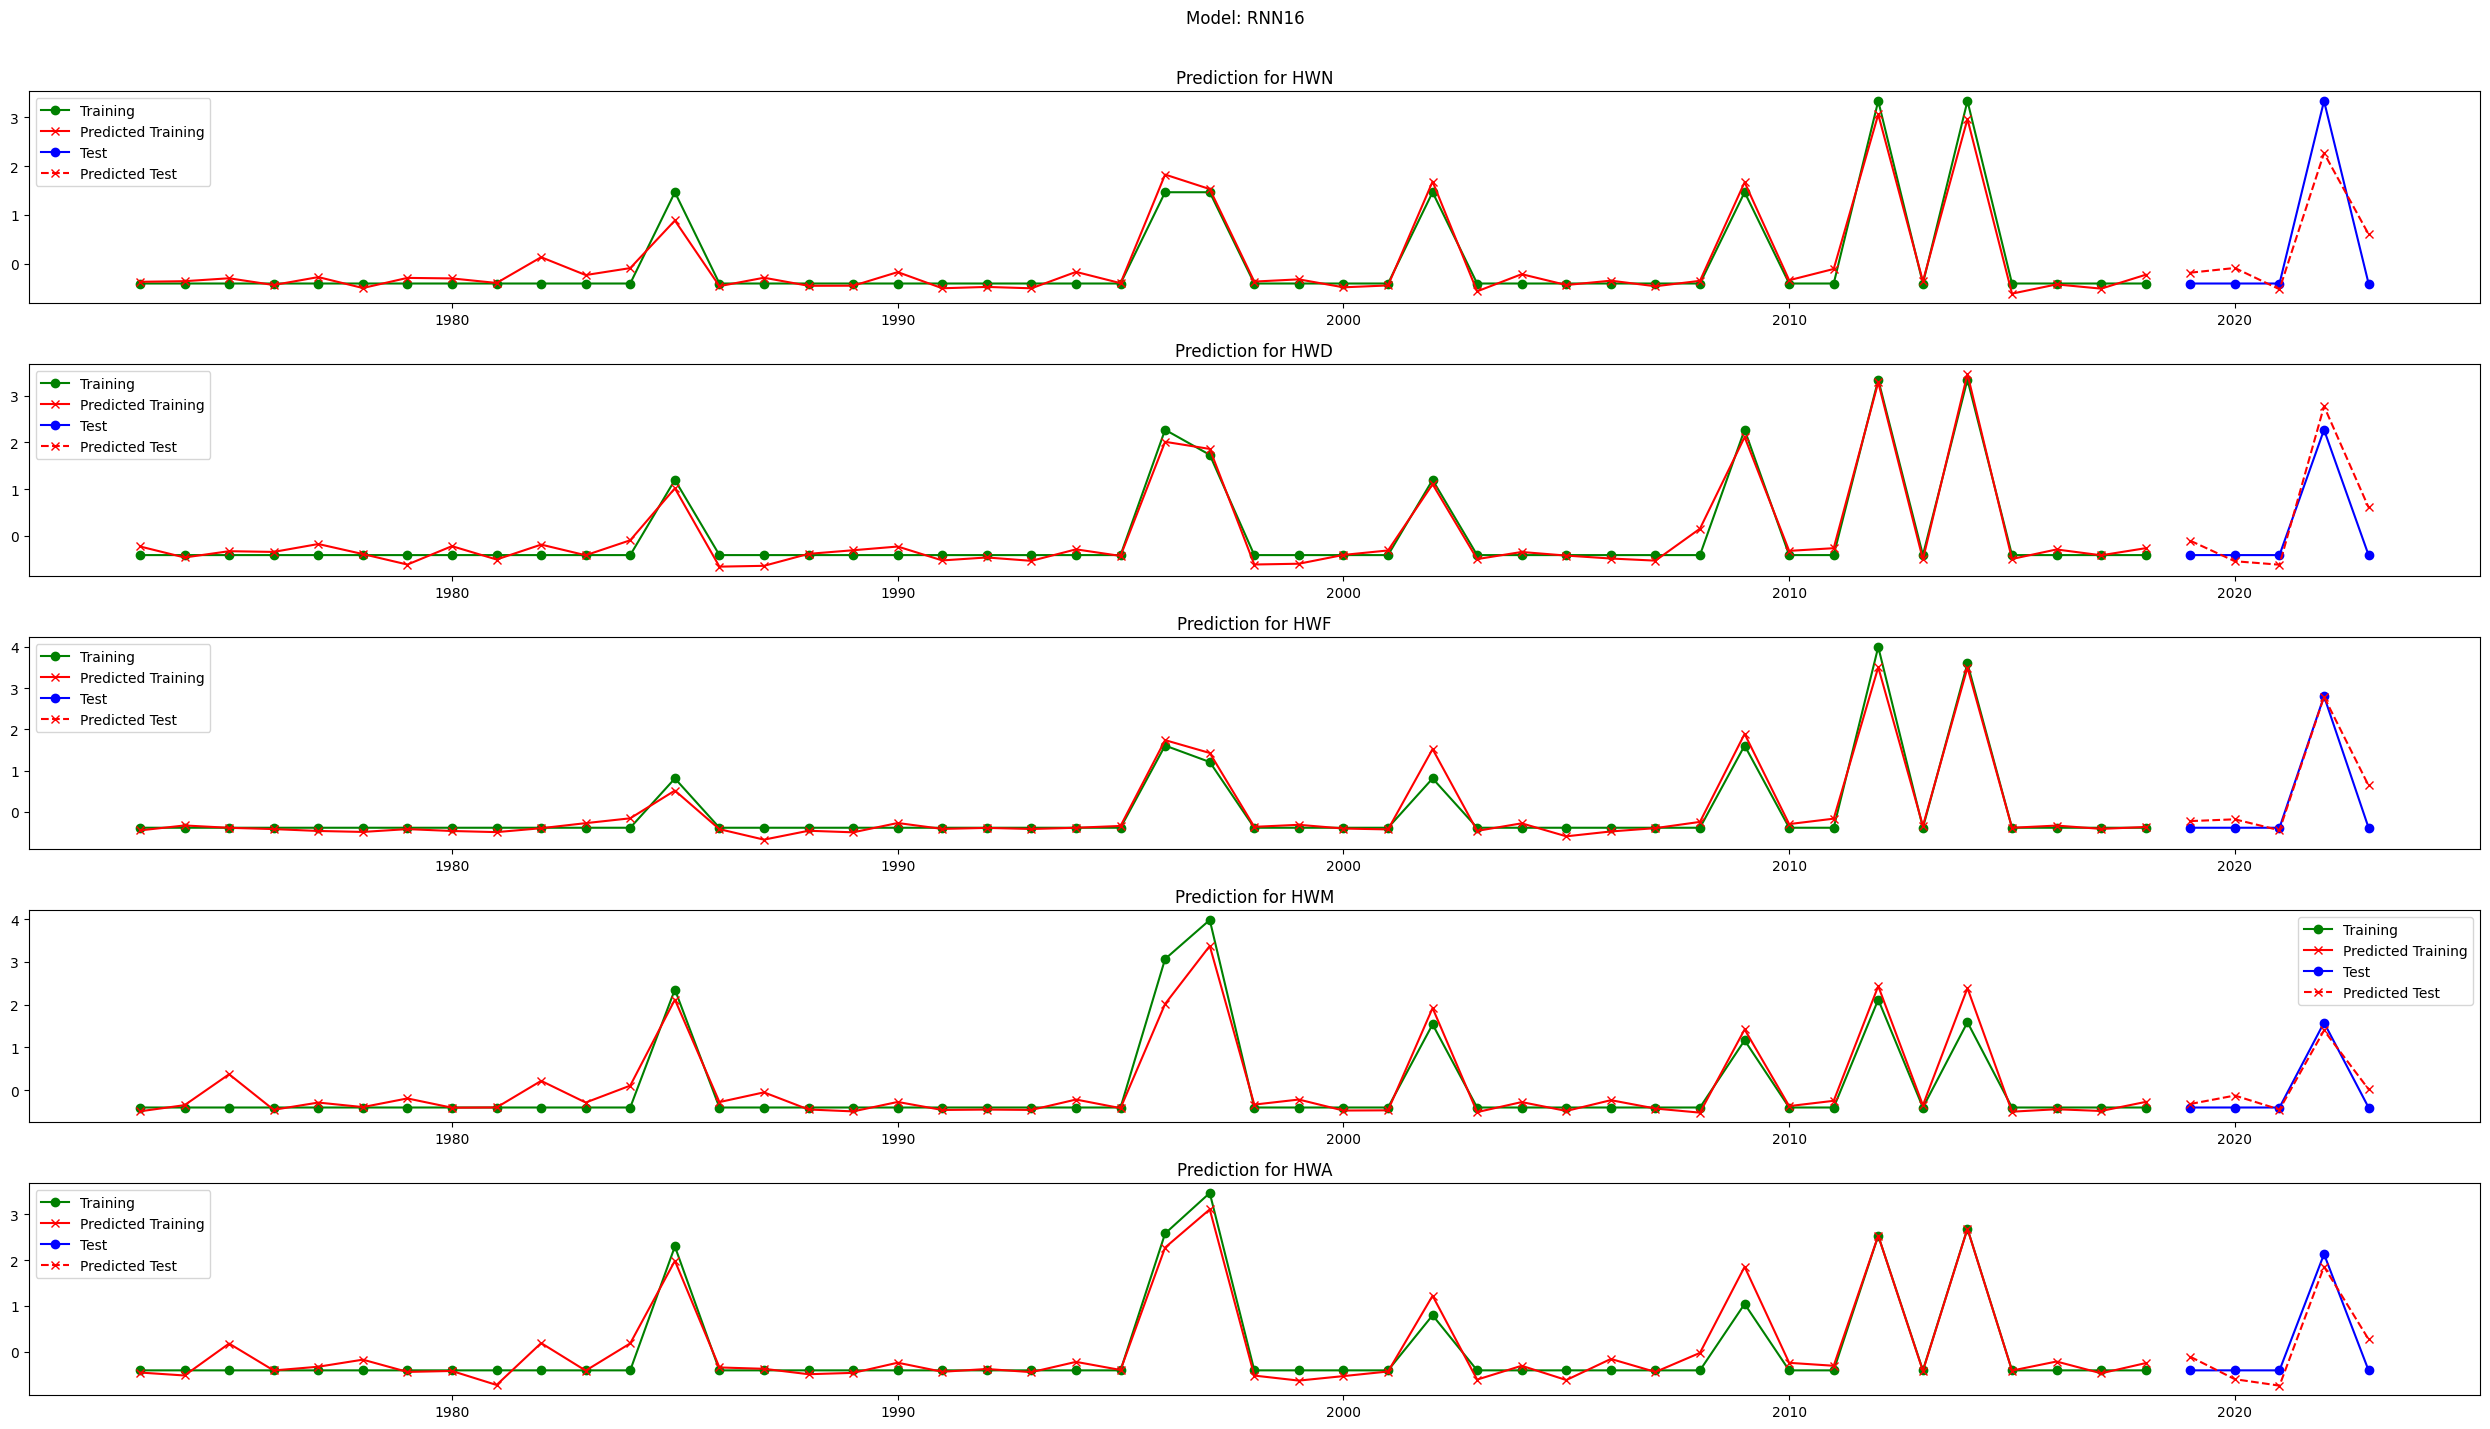

In [38]:
loss_fn = SERA(bounds=bounds,T=100, initial_weight=0.3)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 596ms/step - loss: 35.3453 - mae: 0.7259 - val_loss: 34.1986 - val_mae: 0.8060
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 33.5282 - mae: 0.7377 - val_loss: 32.9933 - val_mae: 0.7900
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 34.1890 - mae: 0.7170 - val_loss: 32.1003 - val_mae: 0.7764
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 32.0416 - mae: 0.6868 - val_loss: 31.2093 - val_mae: 0.7628
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 32.1748 - mae: 0.6882 - val_loss: 30.4548 - val_mae: 0.7506
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 30.2818 - mae: 0.6720 - val_loss: 29.6953 - val_mae: 0.7420
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 30.1655 - mae: 0.6688 - val_loss: 29.0797 - val_mae: 0.7364
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 30.0119 -

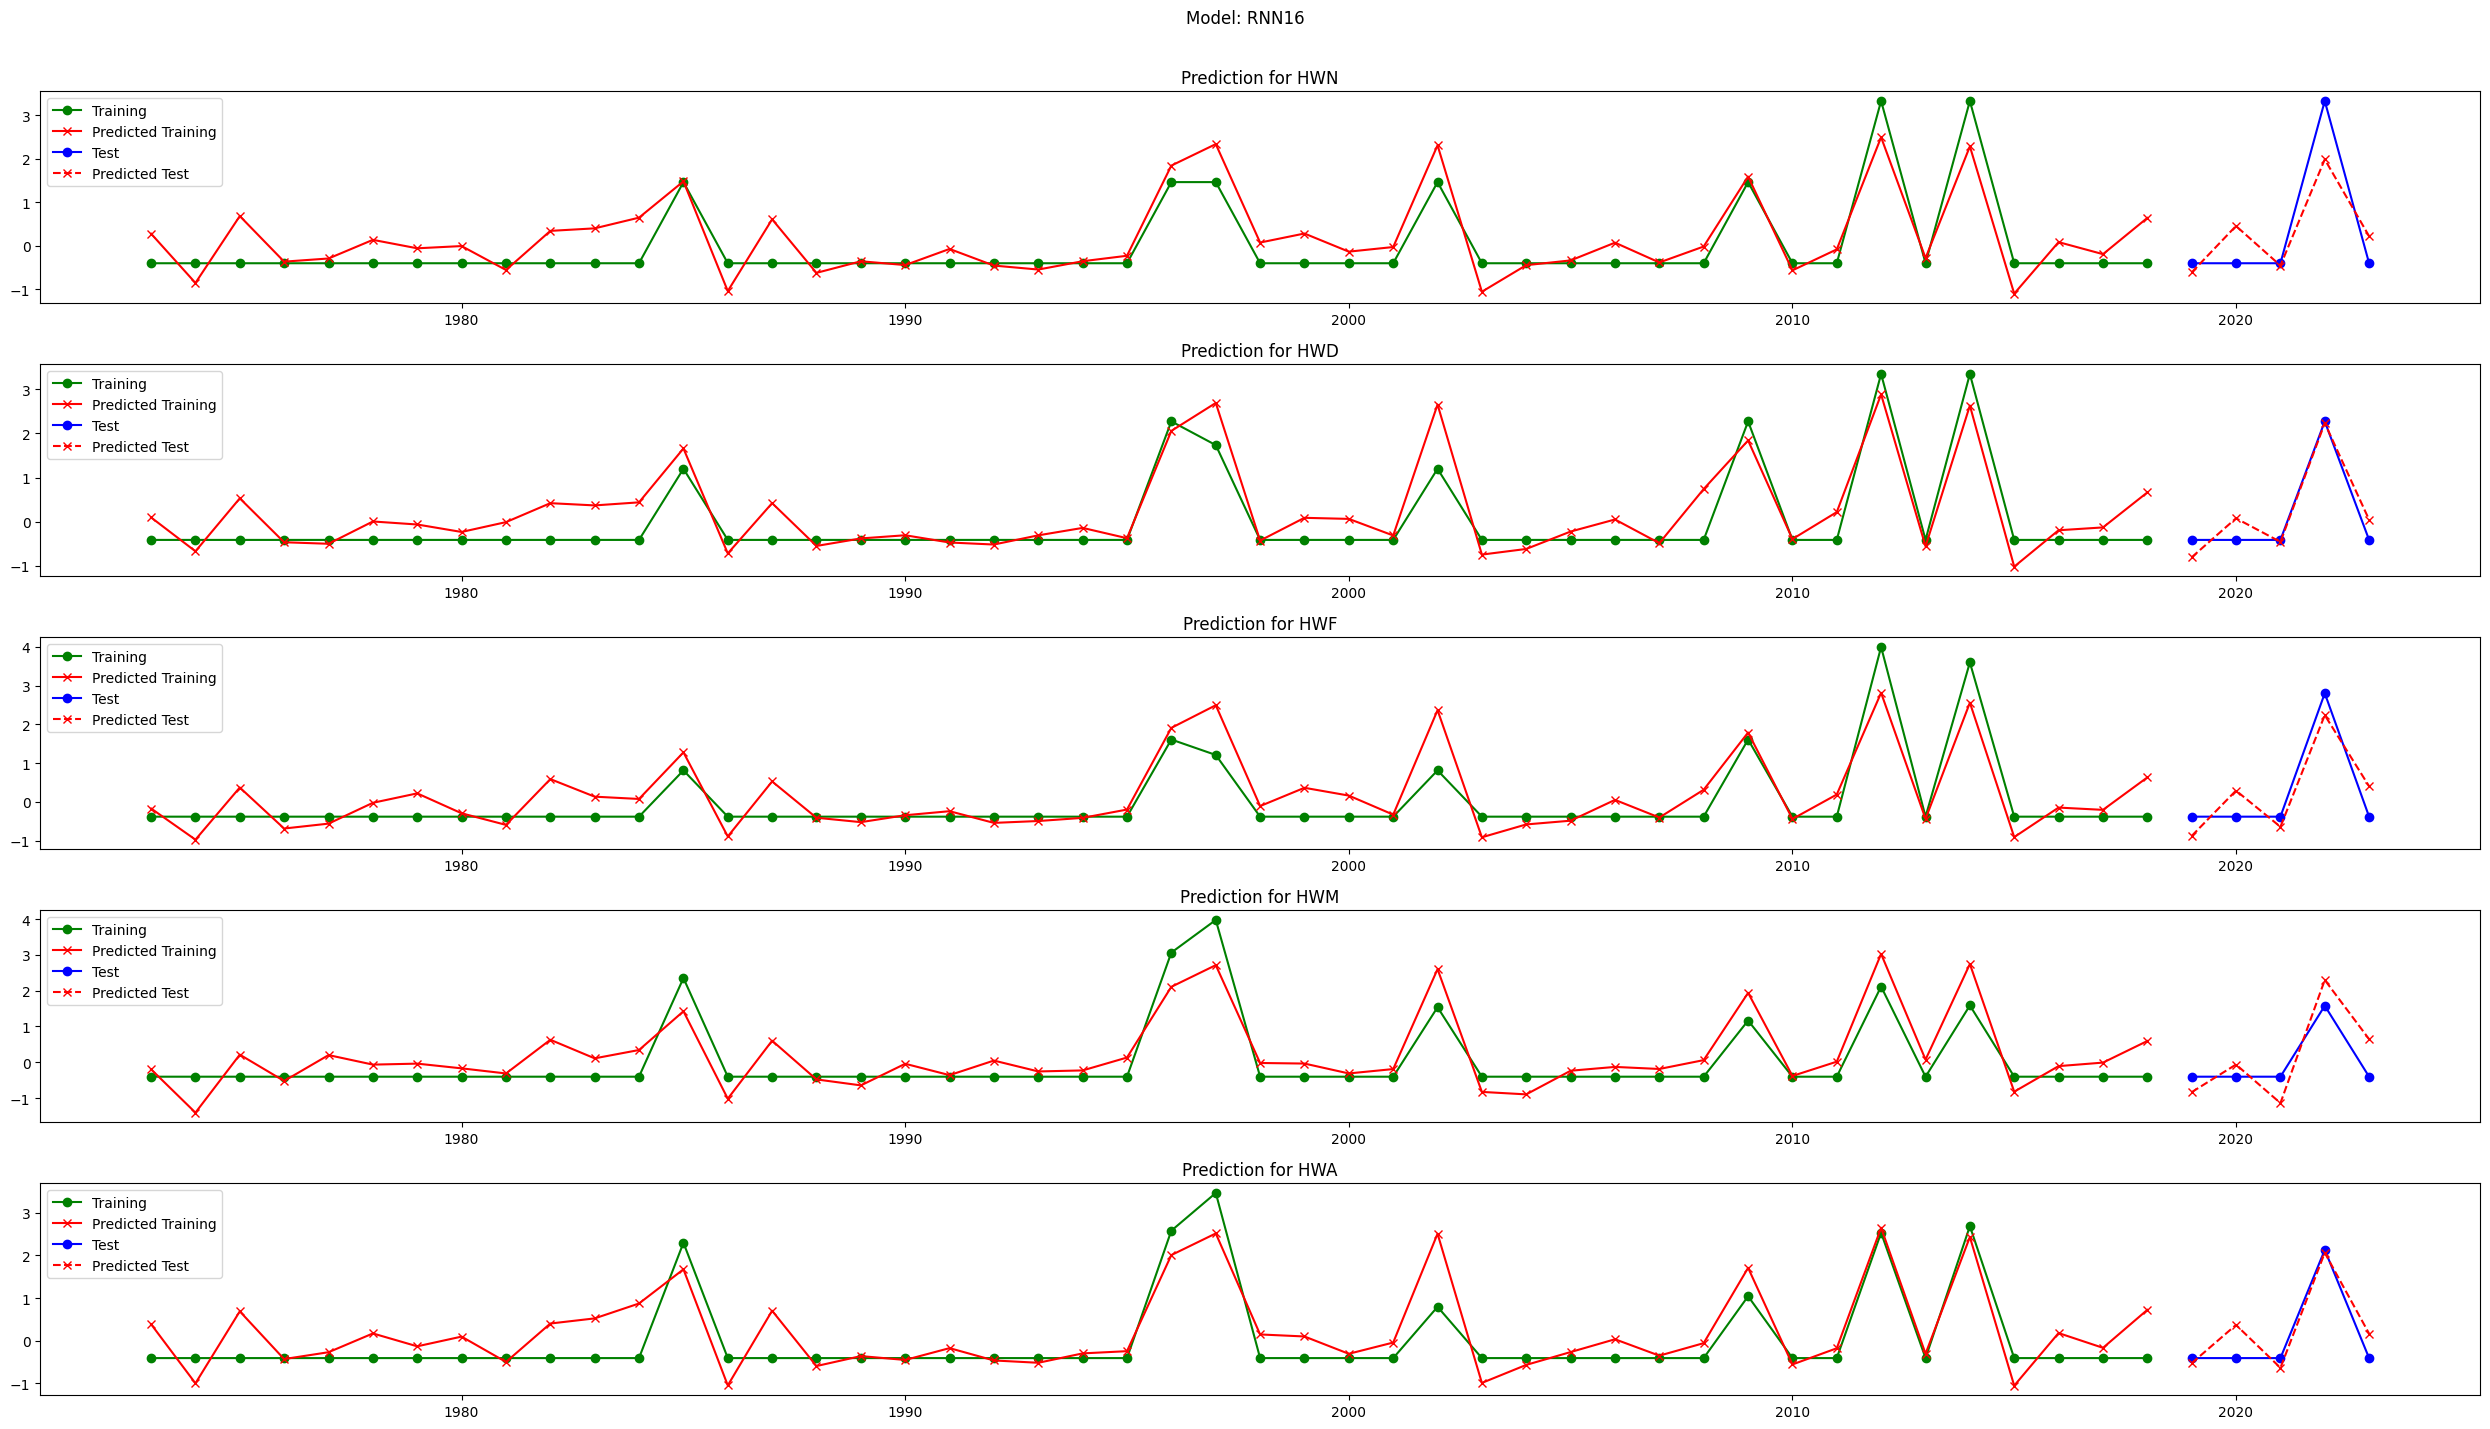

In [40]:
loss_fn = SERA(bounds=bounds,T=100, initial_weight=0.1)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 644ms/step - loss: 24.8427 - mae: 0.9003 - val_loss: 10.1307 - val_mae: 0.8377
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 22.1286 - mae: 0.8712 - val_loss: 9.9049 - val_mae: 0.8332
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 20.0771 - mae: 0.8635 - val_loss: 9.6803 - val_mae: 0.8282
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 21.8914 - mae: 0.8940 - val_loss: 9.4276 - val_mae: 0.8214
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 20.3367 - mae: 0.8746 - val_loss: 9.1922 - val_mae: 0.8142
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 19.6389 - mae: 0.8921 - val_loss: 9.0397 - val_mae: 0.8087
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 18.4630 - mae: 0.8610 - val_loss: 8.9062 - val_mae: 0.8028
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 19.8649 - mae: 

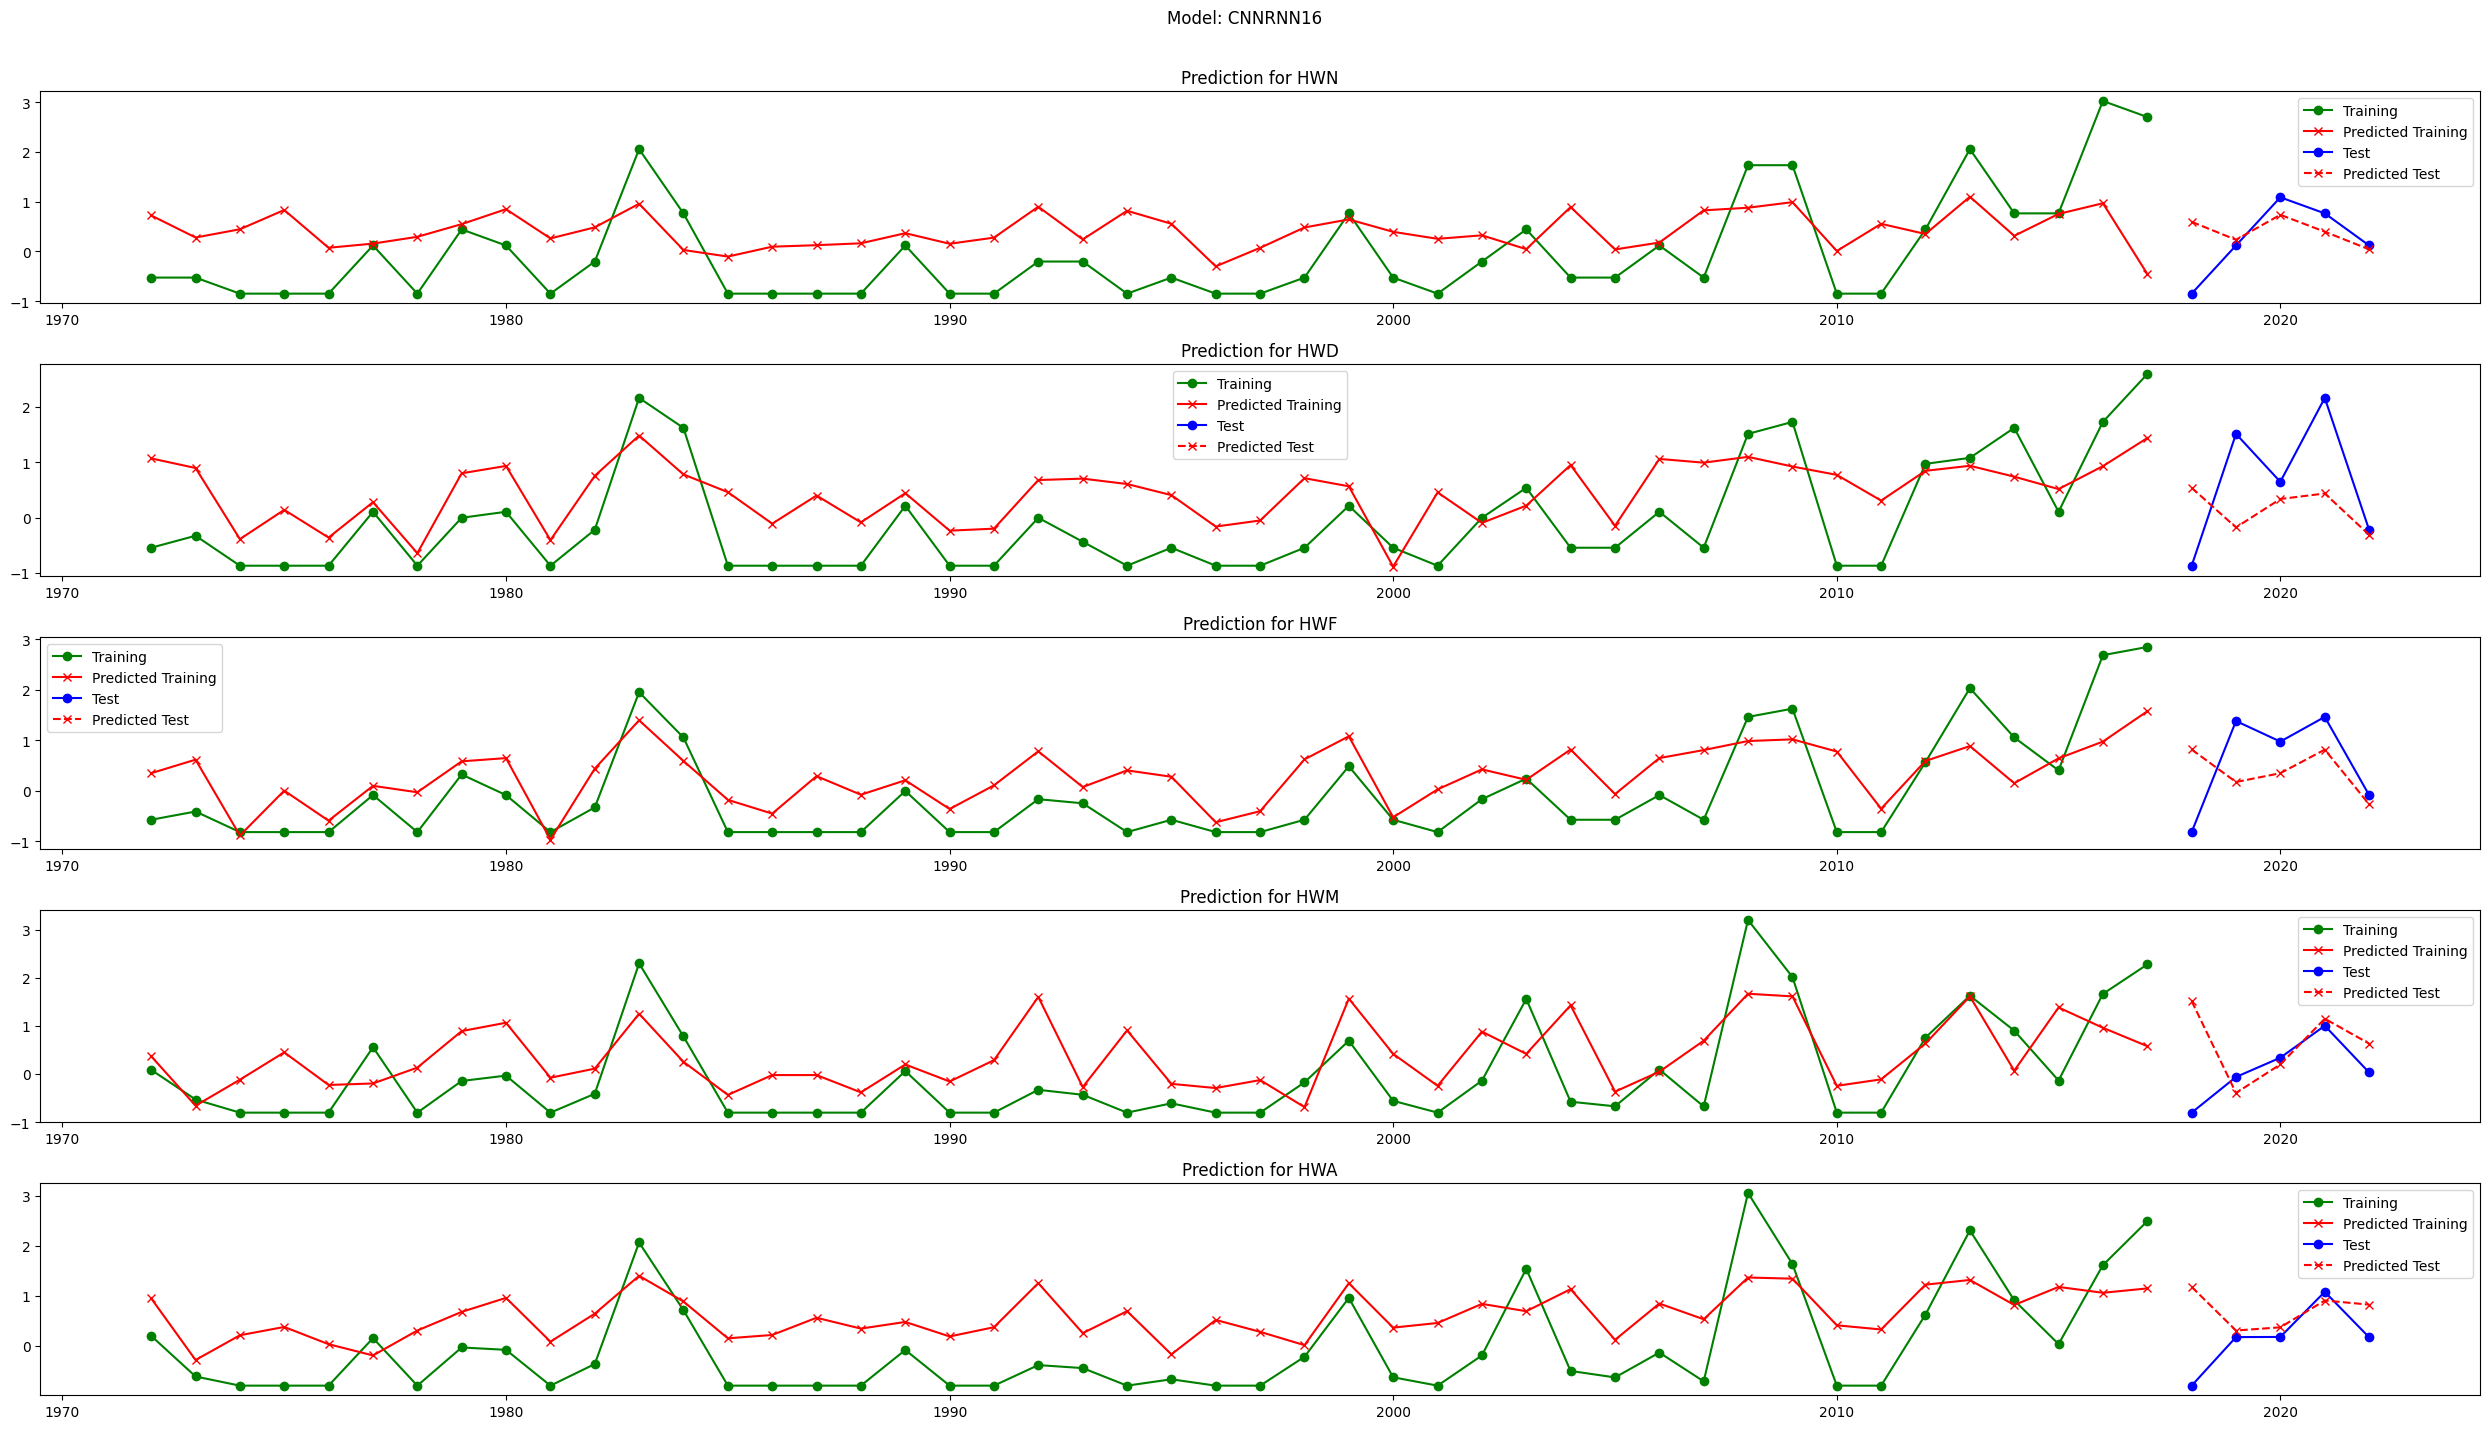

In [42]:
loss_fn = SERA(bounds=bounds,T=100, initial_weight=0.1)

id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 621ms/step - loss: 32.4743 - mae: 0.8654 - val_loss: 14.3584 - val_mae: 0.7641
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 32.5181 - mae: 0.8406 - val_loss: 14.0285 - val_mae: 0.7595
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 30.9072 - mae: 0.8425 - val_loss: 13.6711 - val_mae: 0.7527
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 30.7050 - mae: 0.8373 - val_loss: 13.3063 - val_mae: 0.7444
Epoch 5/200
6/6 [==============================] - 0s 10ms/step - loss: 30.8529 - mae: 0.8358 - val_loss: 13.0051 - val_mae: 0.7379
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 27.9697 - mae: 0.8254 - val_loss: 12.7630 - val_mae: 0.7340
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 26.2285 - mae: 0.7896 - val_loss: 12.4952 - val_mae: 0.7272
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 27.3410 

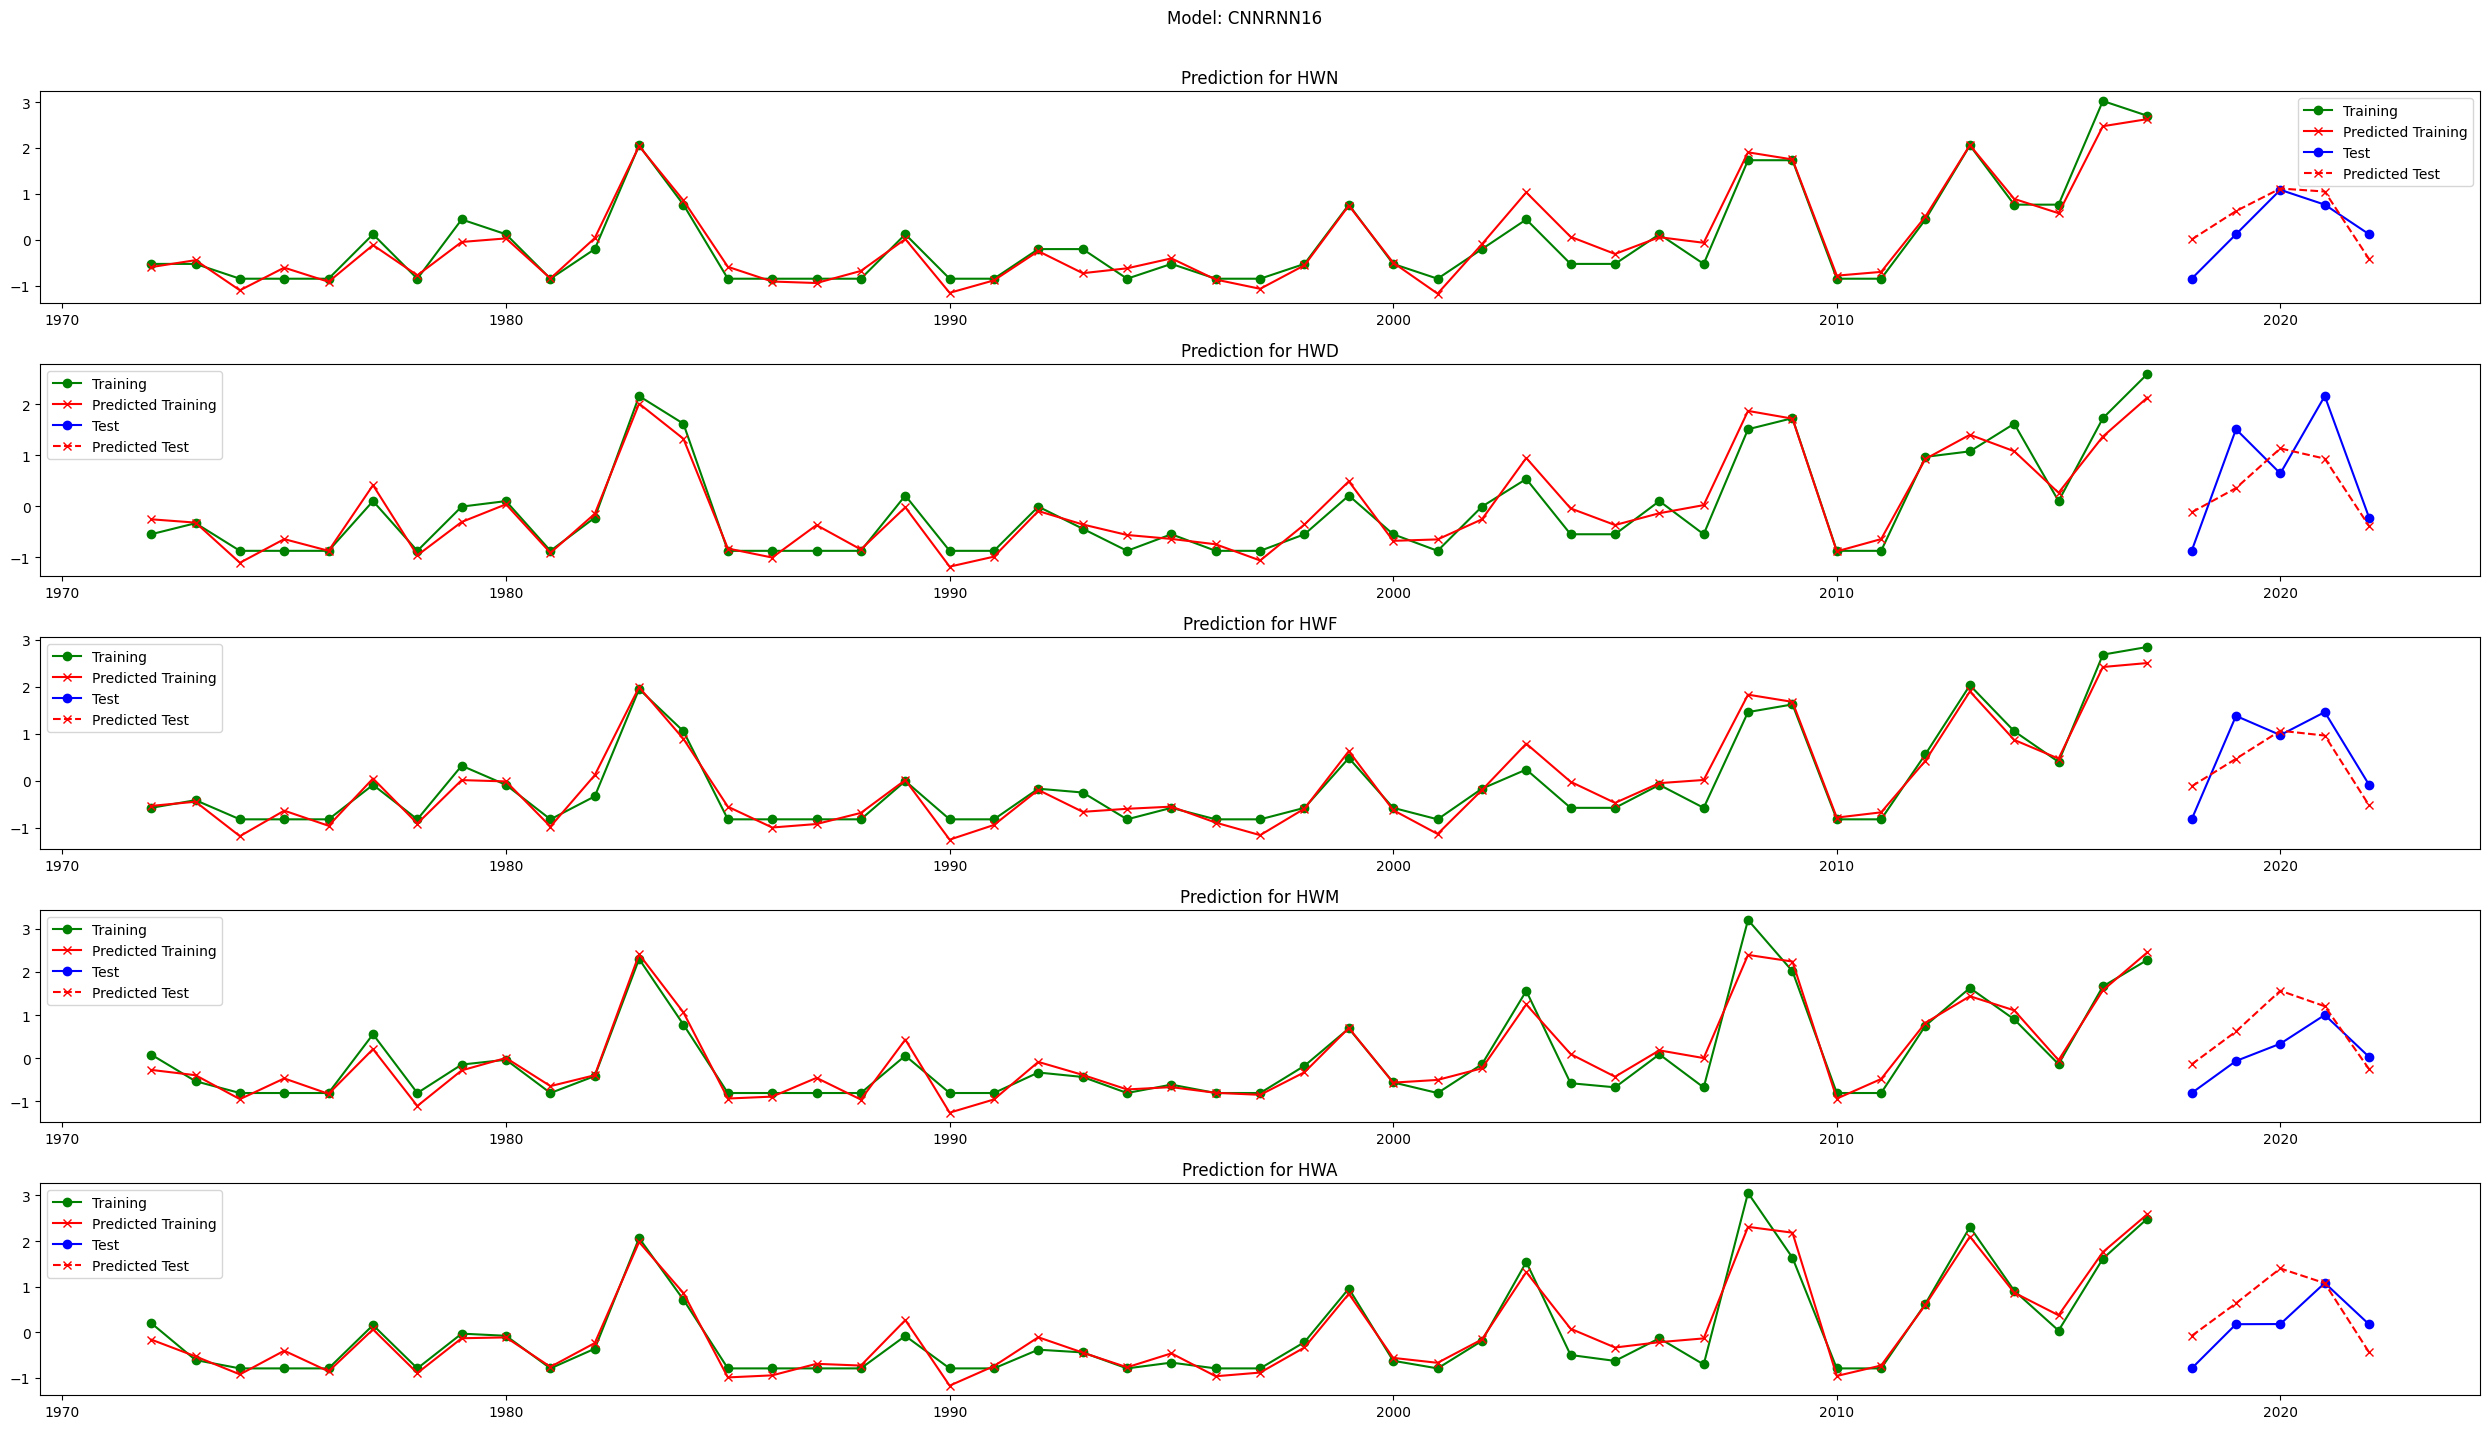

In [54]:
loss_fn = SERA(bounds=bounds,T=100, initial_weight=0.3)

id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 650ms/step - loss: 14.5626 - mae: 0.6749 - val_loss: 104.7321 - val_mae: 1.1779
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 17.3215 - mae: 0.6758 - val_loss: 104.1094 - val_mae: 1.1701
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 16.9722 - mae: 0.6644 - val_loss: 103.4255 - val_mae: 1.1618
Epoch 4/200
6/6 [==============================] - 0s 10ms/step - loss: 16.5670 - mae: 0.6586 - val_loss: 102.7623 - val_mae: 1.1546
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 15.6270 - mae: 0.6608 - val_loss: 102.1378 - val_mae: 1.1477
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 15.6976 - mae: 0.6663 - val_loss: 101.5621 - val_mae: 1.1428
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 16.2414 - mae: 0.6589 - val_loss: 100.9405 - val_mae: 1.1377
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 1

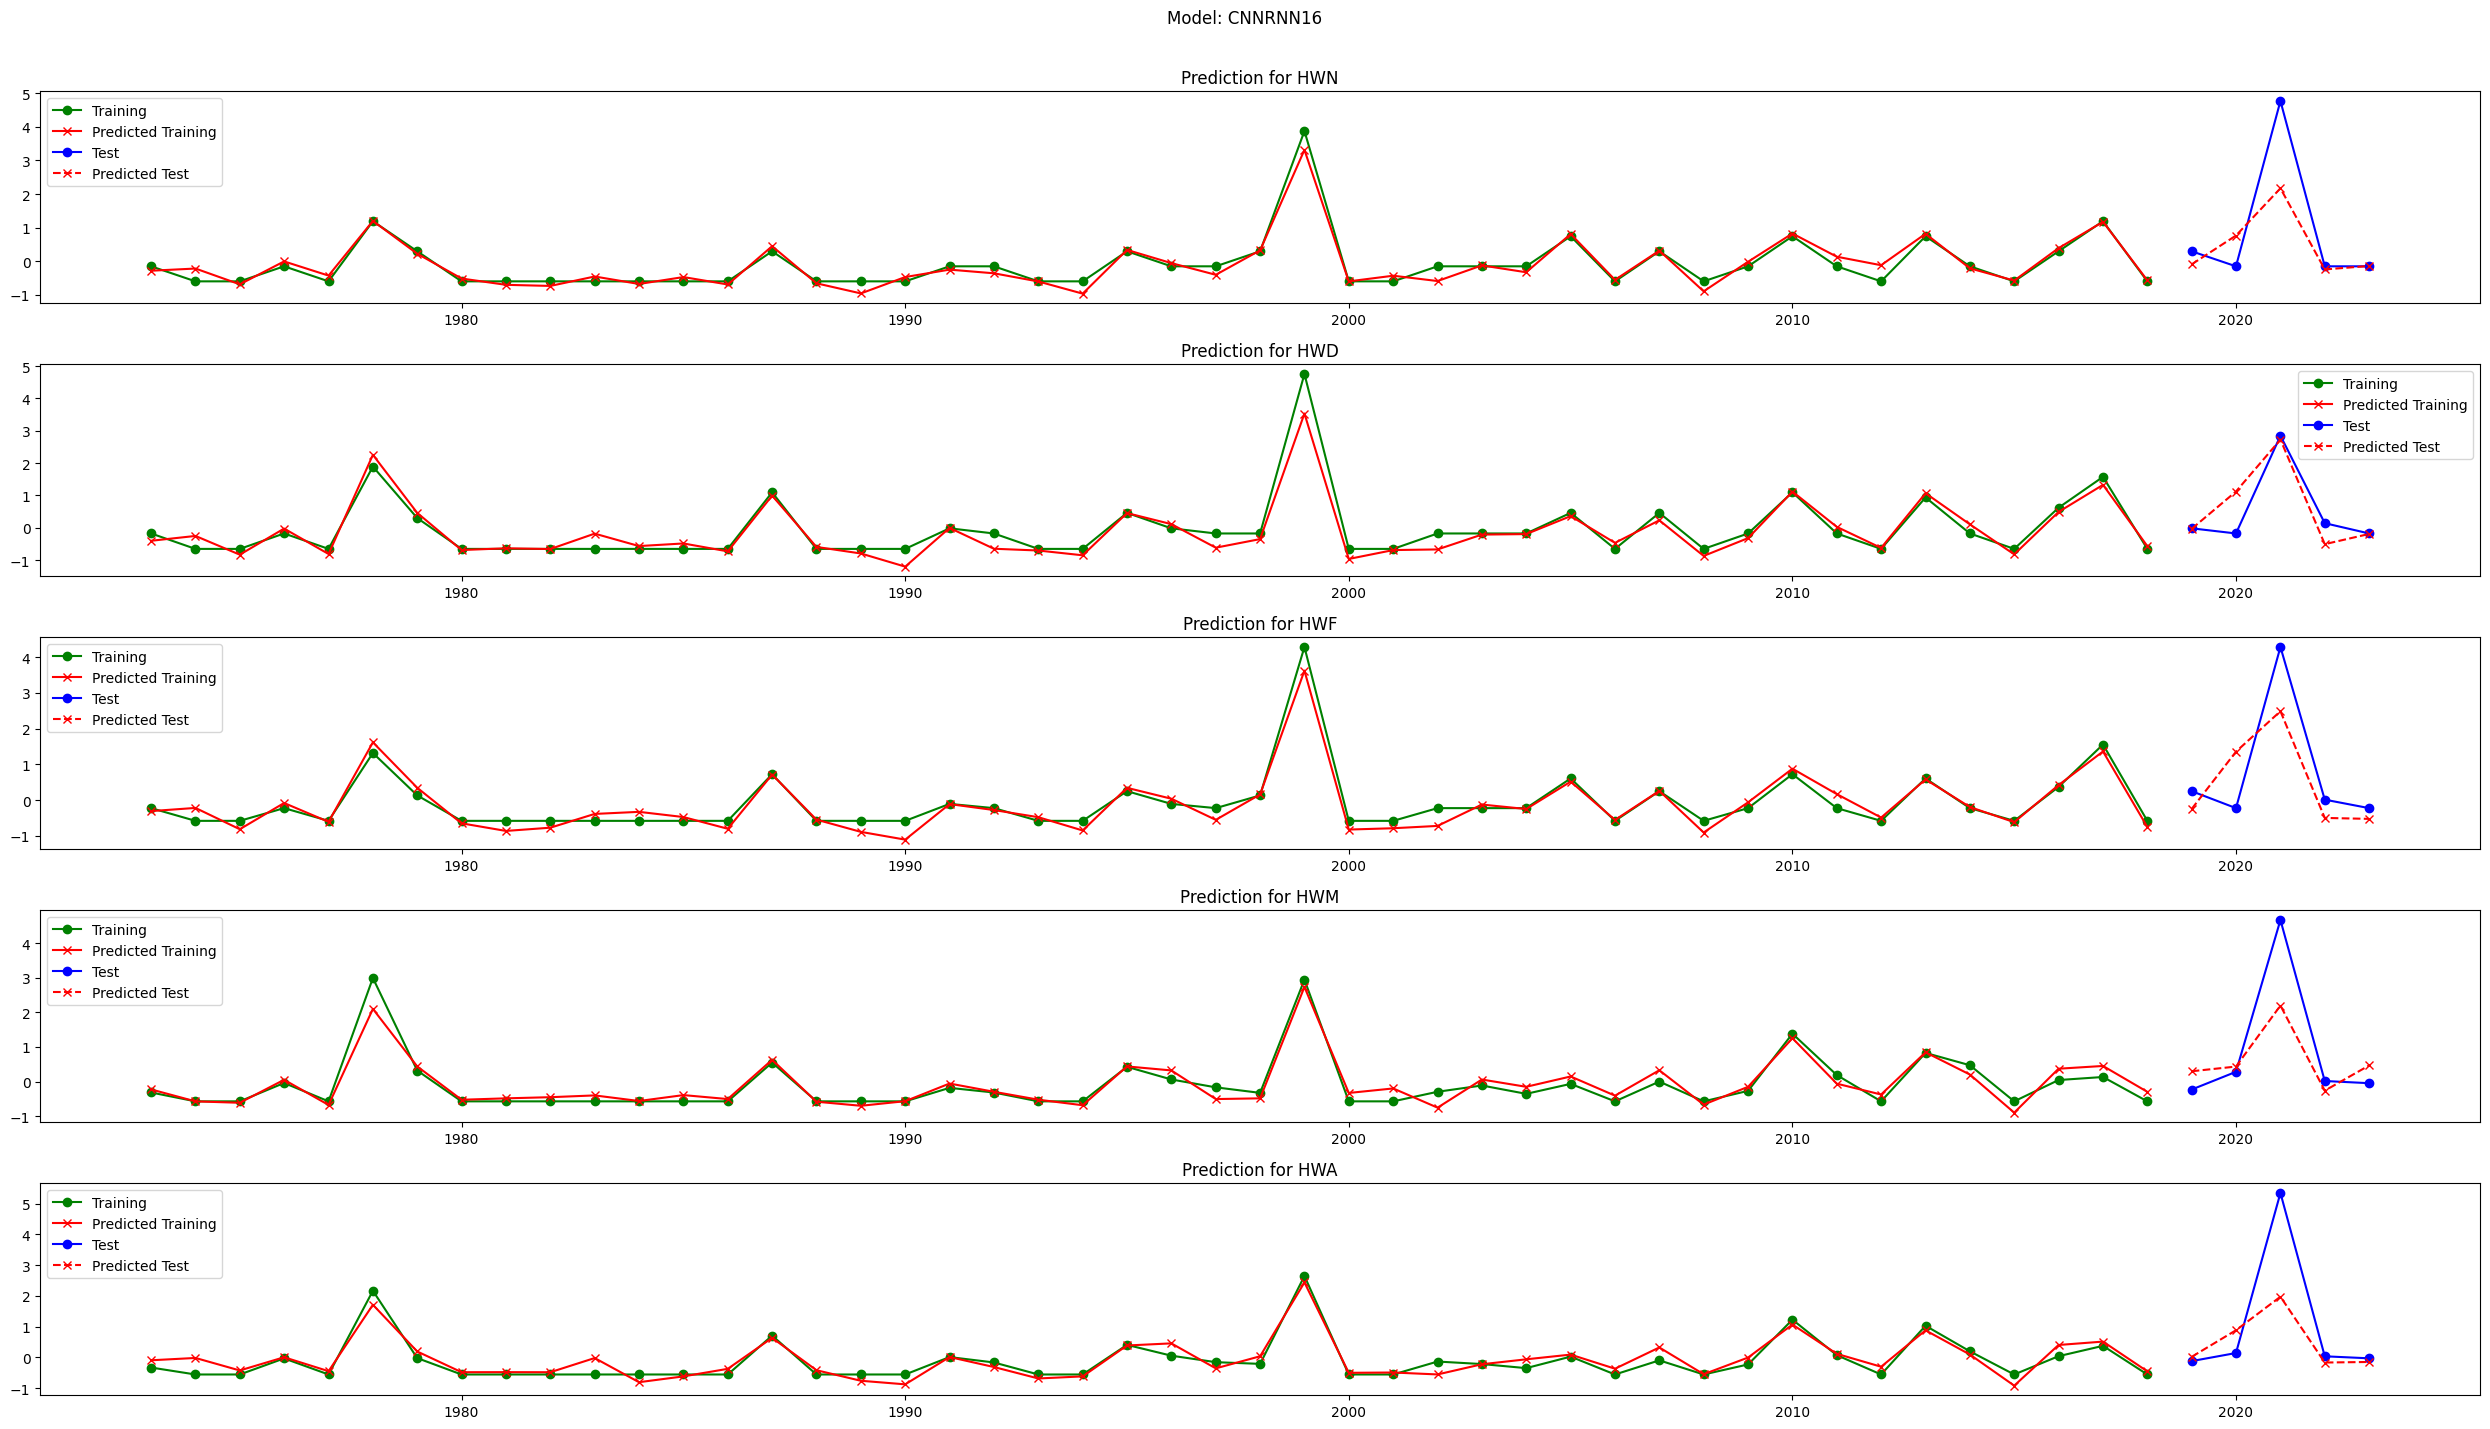

In [55]:
loss_fn = SERA(bounds=bounds,T=100, initial_weight=0.1)

id = "ecf2577f"
season = 5
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 669ms/step - loss: 25.2014 - mae: 0.7730 - val_loss: 107.3751 - val_mae: 1.2037
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 27.0552 - mae: 0.7126 - val_loss: 106.0364 - val_mae: 1.1763
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 25.3417 - mae: 0.6957 - val_loss: 104.9044 - val_mae: 1.1543
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 24.5868 - mae: 0.6646 - val_loss: 103.9021 - val_mae: 1.1341
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 22.5613 - mae: 0.6327 - val_loss: 103.1555 - val_mae: 1.1160
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 23.1407 - mae: 0.6436 - val_loss: 102.4471 - val_mae: 1.0984
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 22.7839 - mae: 0.6272 - val_loss: 101.8599 - val_mae: 1.0882
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 21

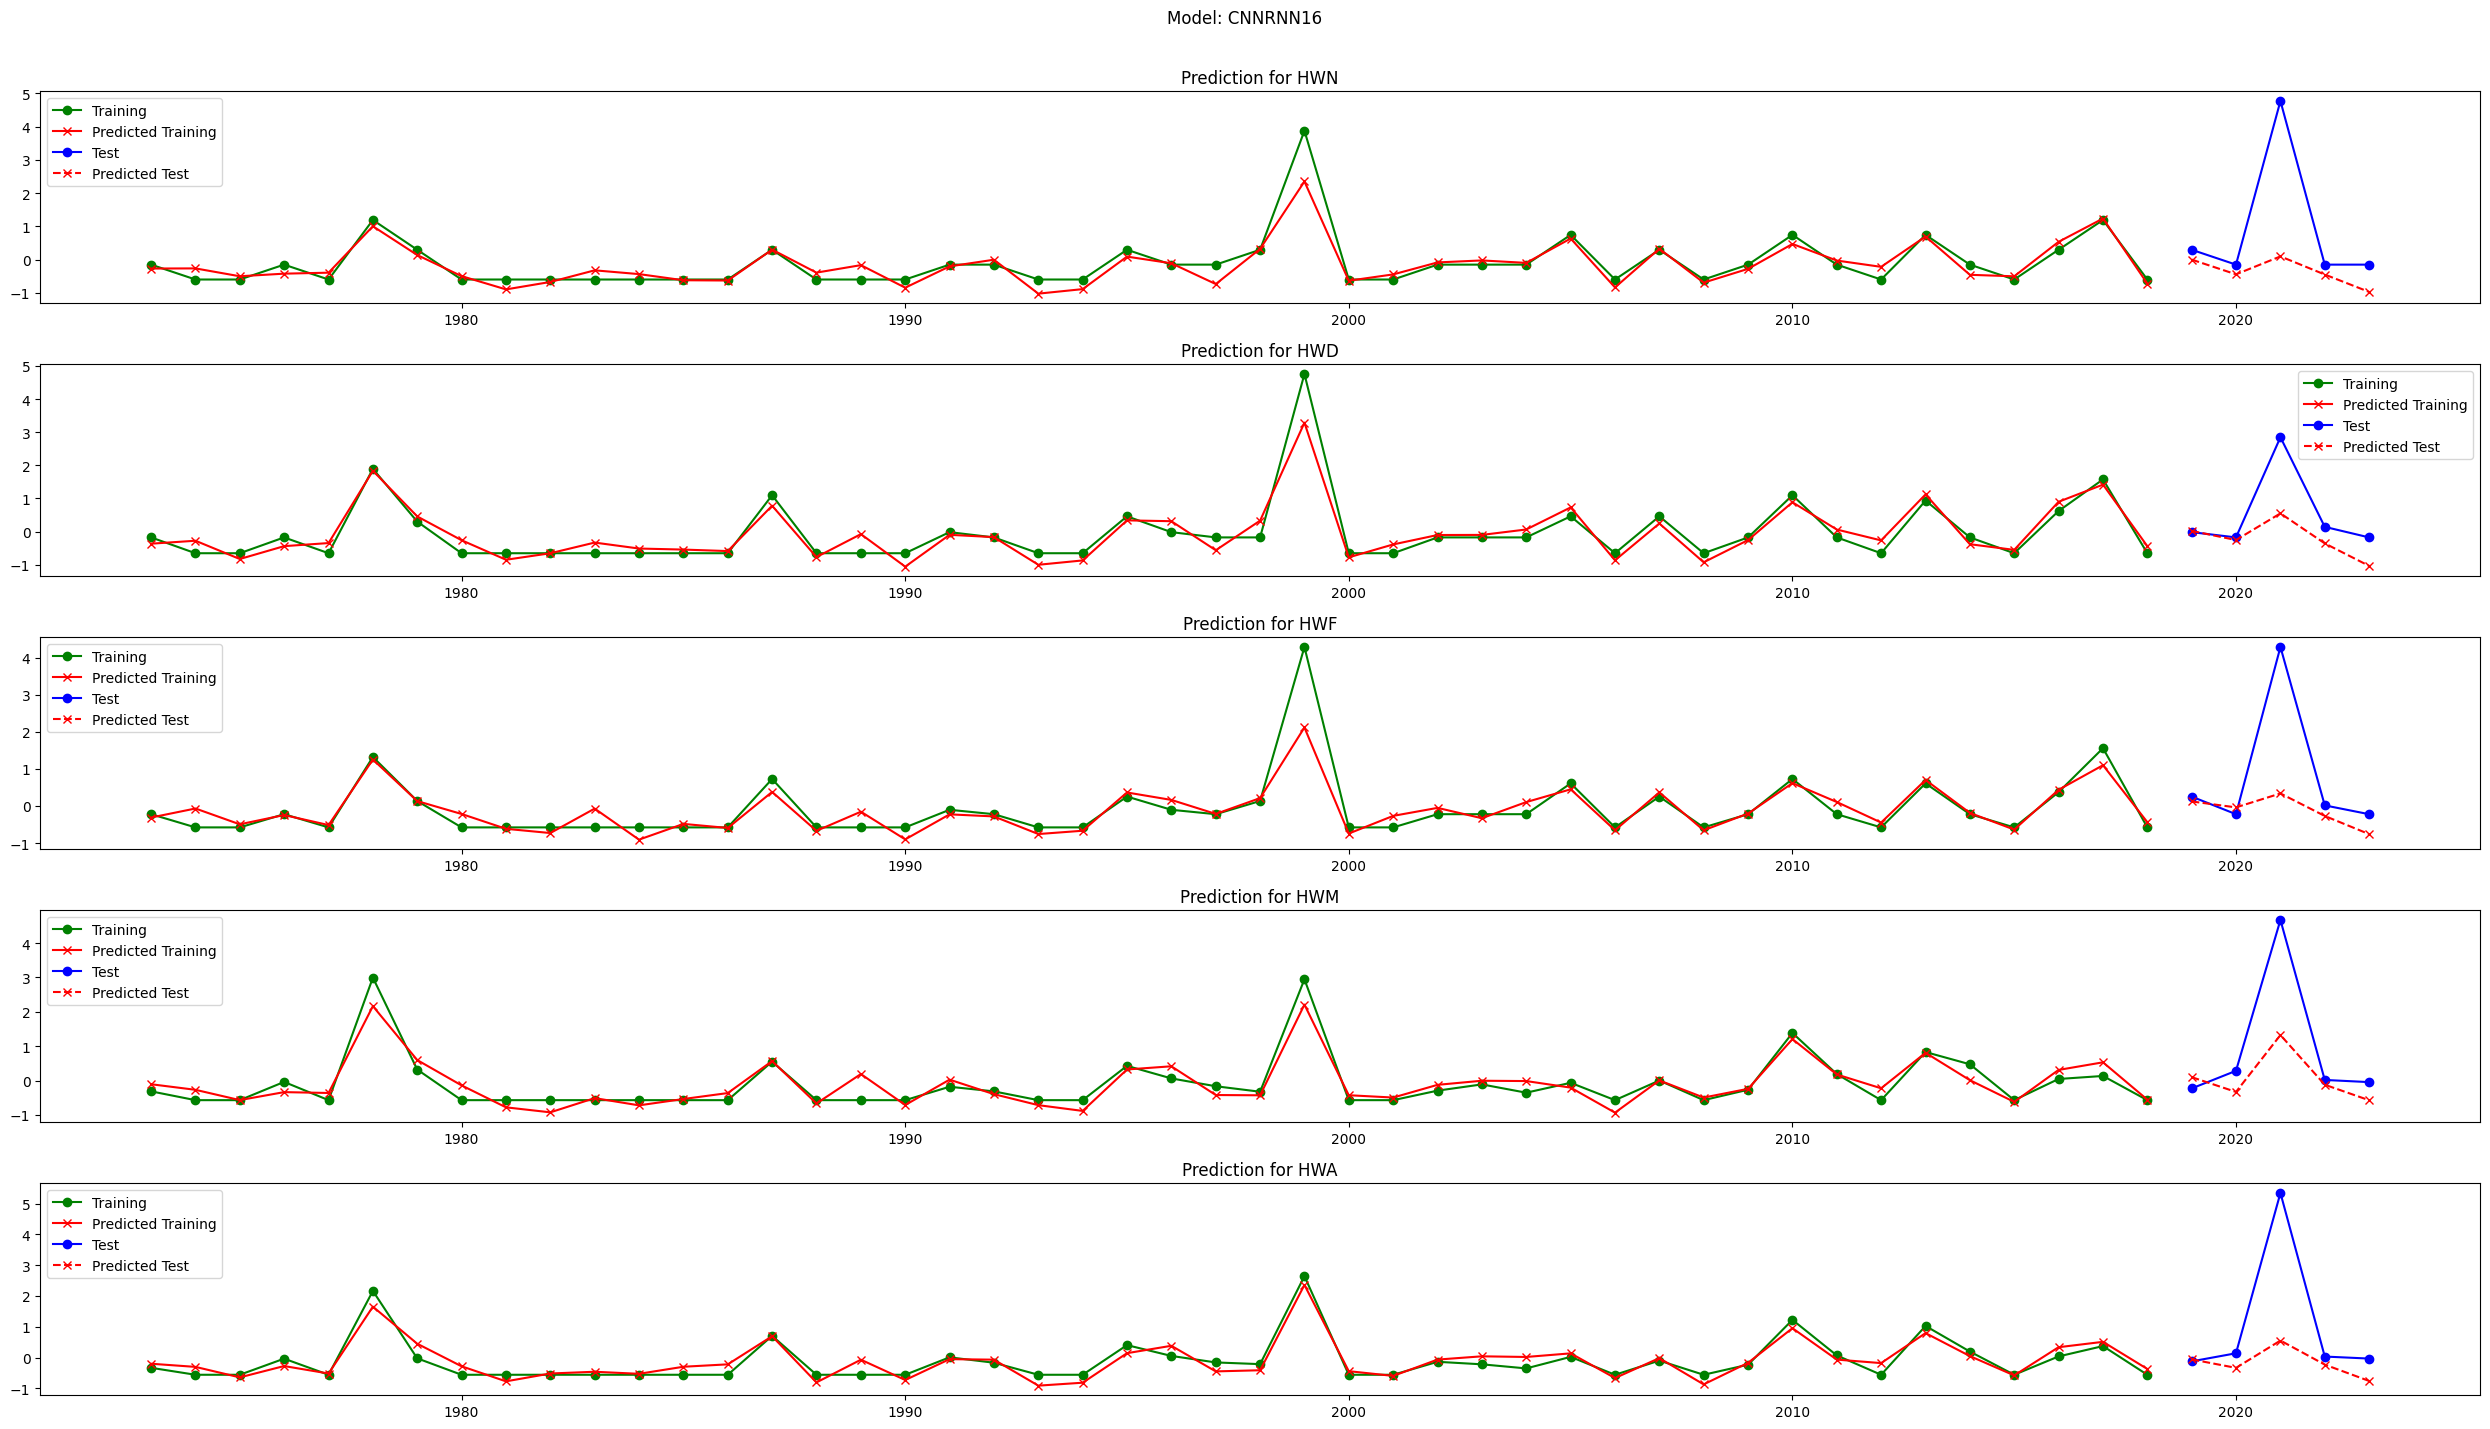

In [56]:
loss_fn = SERA(bounds=bounds,T=100, initial_weight=0.3)

id = "ecf2577f"
season = 5
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Looks that for december there is no change between initial weighting 0.1 and 0.3.

## Season specific relevance fn opt but adjusting initial weight higher

### January

In [42]:
hws_jan = hws[hws.index.month==1]
hws_index = hws_jan[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = create_relevance_function(hws_index)

[-0.88172761 -0.53086416  2.61057215 12.09144245]


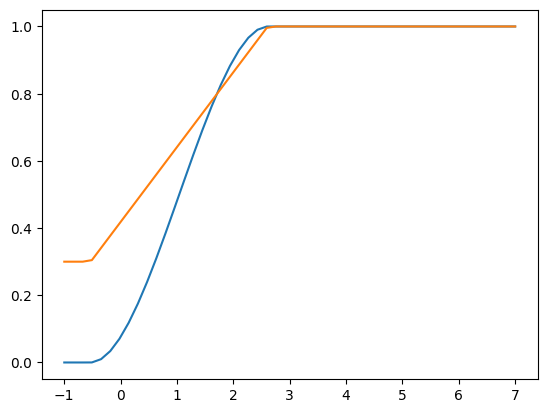

In [ ]:
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, u, max(hws_index))
bounds = np.sort(bounds)
print(bounds)
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, linear_phi_2(x, bounds))

Epoch 1/200
6/6 [==============================] - 18s 669ms/step - loss: 32.7778 - mae: 0.9802 - val_loss: 16.7817 - val_mae: 0.9348
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 30.2298 - mae: 0.9493 - val_loss: 16.5473 - val_mae: 0.9310
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 27.6579 - mae: 0.9346 - val_loss: 16.2141 - val_mae: 0.9241
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 28.1905 - mae: 0.9454 - val_loss: 15.8968 - val_mae: 0.9159
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 29.3722 - mae: 0.9431 - val_loss: 15.5798 - val_mae: 0.9078
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 25.6117 - mae: 0.9048 - val_loss: 15.4578 - val_mae: 0.9048
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 25.7827 - mae: 0.9122 - val_loss: 15.2012 - val_mae: 0.8975
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 25.3175 -

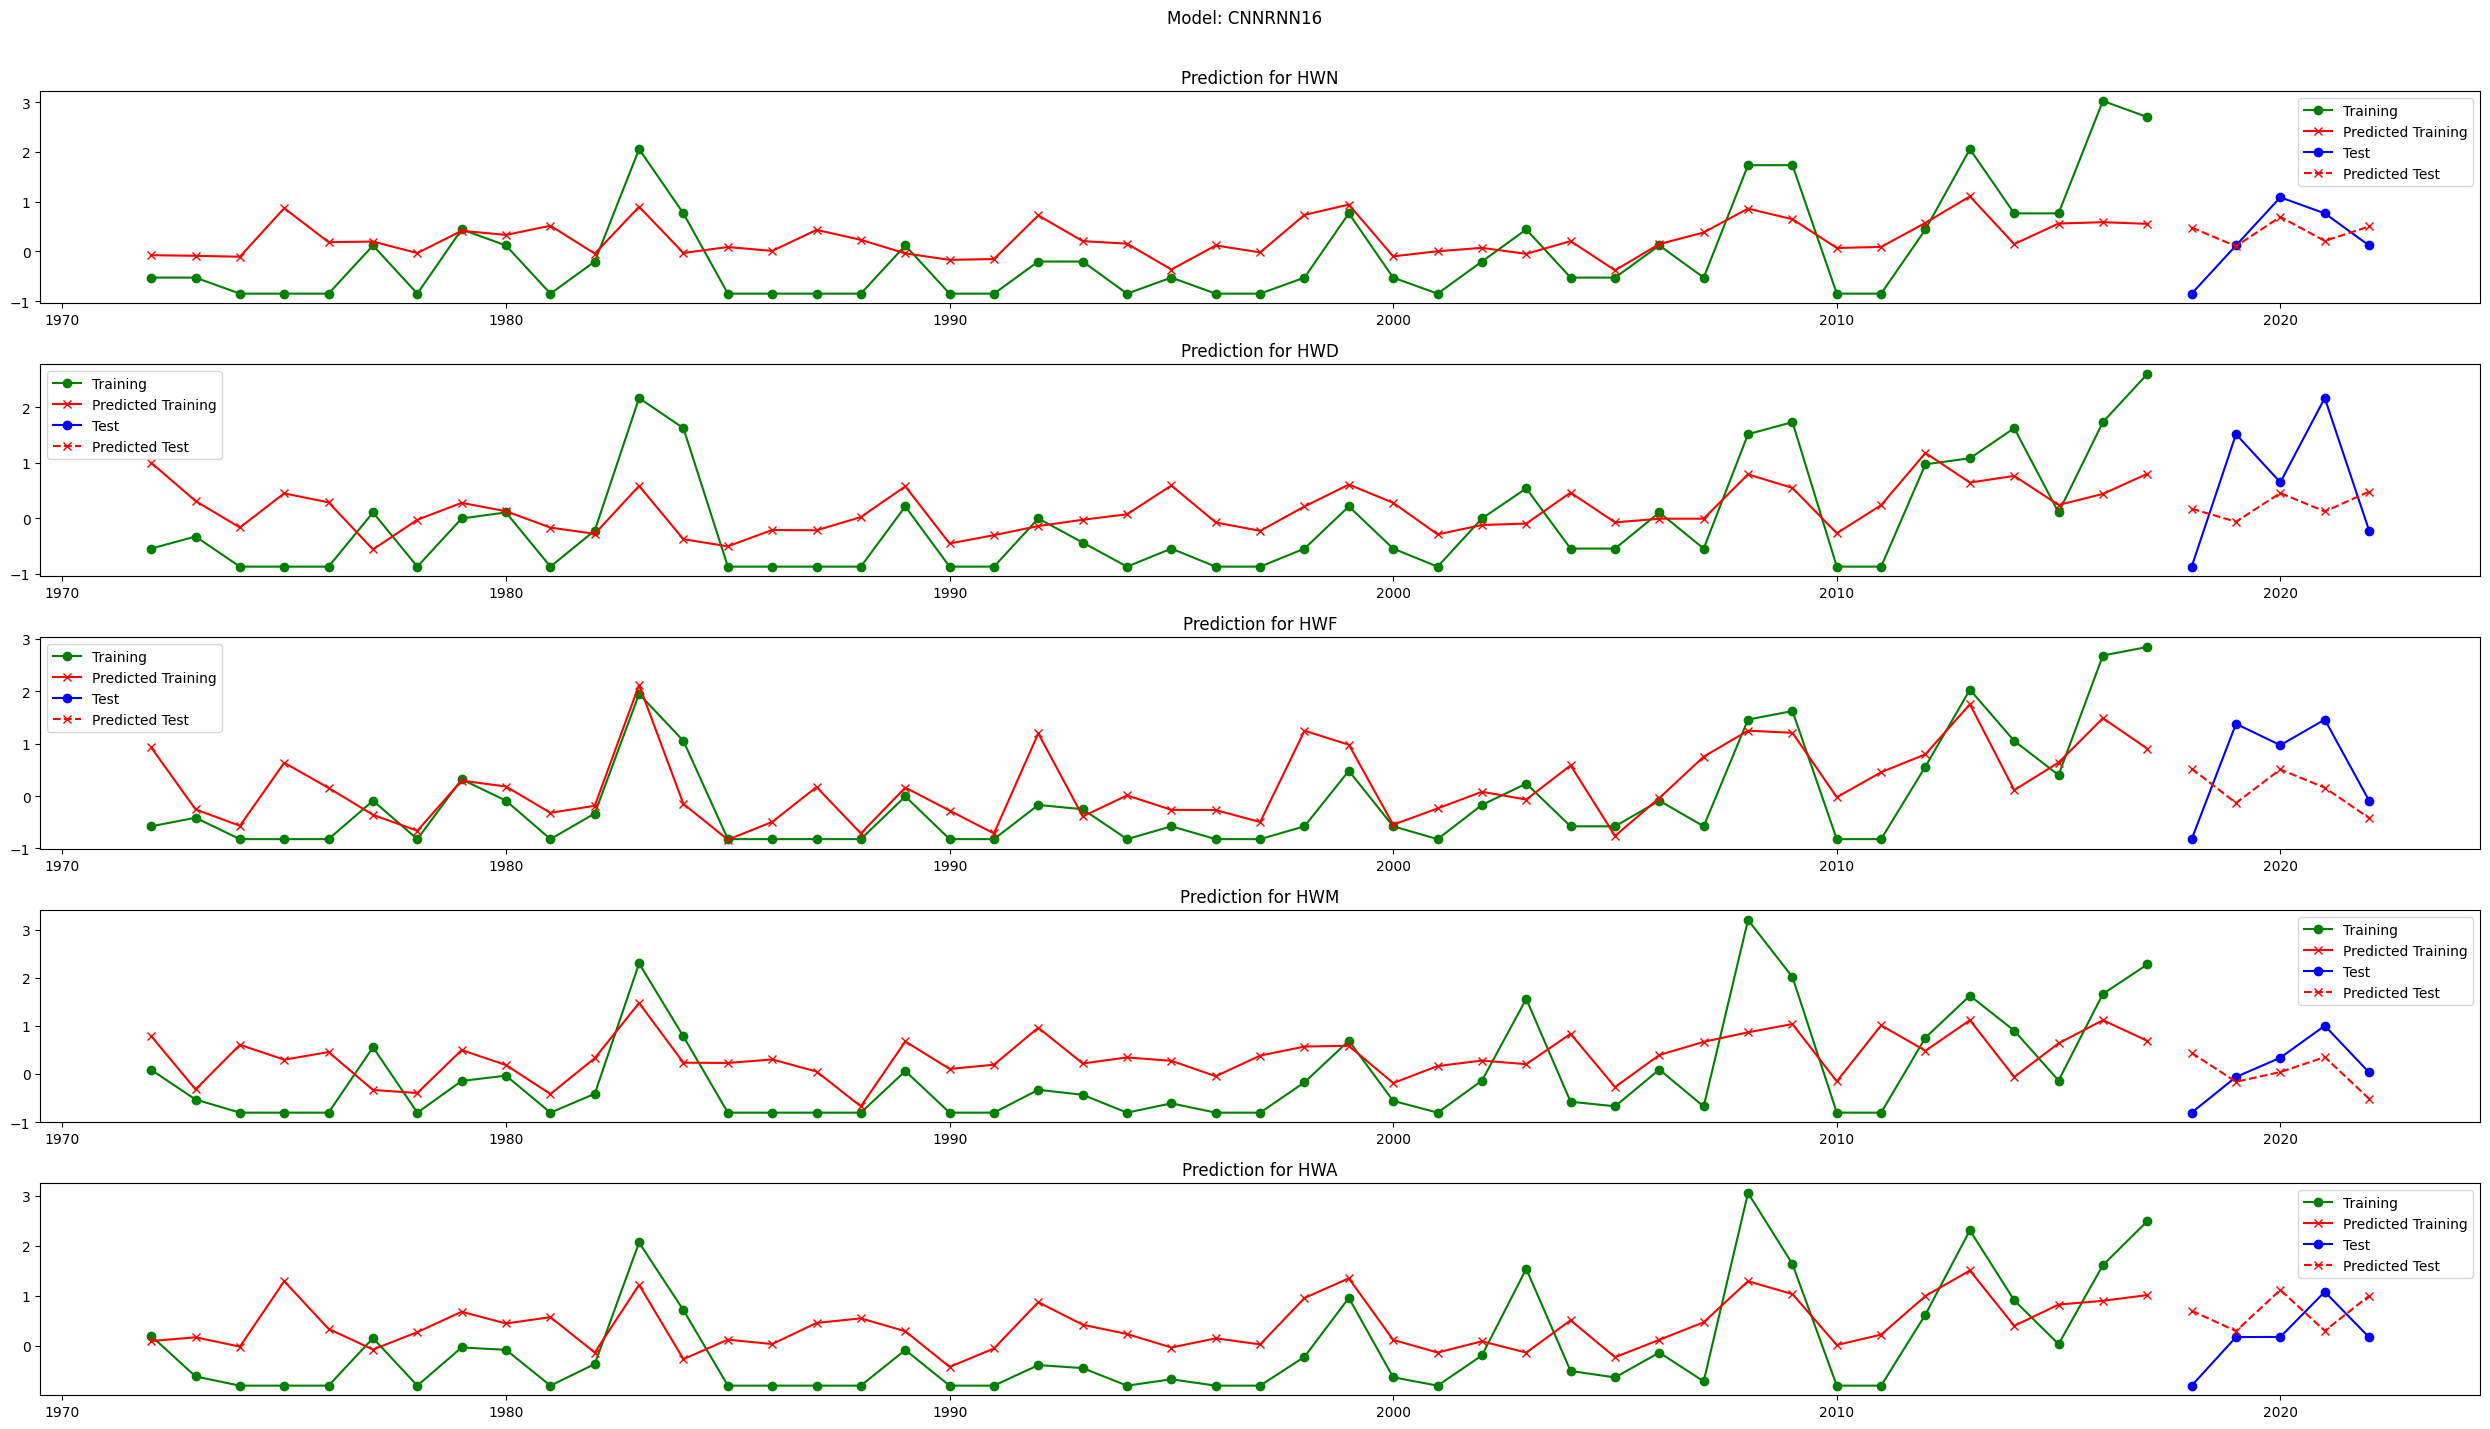

In [45]:
loss_fn = SERA(bounds=bounds,T=100)

id = "d7101242"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

### December

In [46]:
hws_dec = hws[hws.index.month==12]
hws_index = hws_dec[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = create_relevance_function(hws_index)

[-0.89190692 -0.53086416  1.86261112  4.44328628]


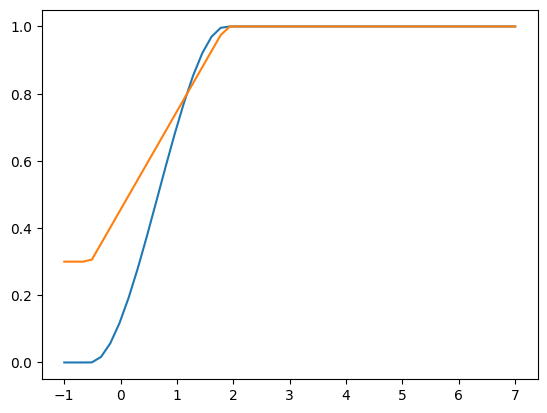

In [47]:
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, u, max(hws_index))
bounds = np.sort(bounds)
print(bounds)
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, linear_phi_2(x, bounds))

Epoch 1/200
6/6 [==============================] - 16s 673ms/step - loss: 31.1301 - mae: 0.8113 - val_loss: 21.2507 - val_mae: 0.8997
Epoch 2/200
6/6 [==============================] - 0s 11ms/step - loss: 29.2150 - mae: 0.8077 - val_loss: 20.8074 - val_mae: 0.8970
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 29.3428 - mae: 0.7924 - val_loss: 20.4084 - val_mae: 0.8958
Epoch 4/200
6/6 [==============================] - 0s 12ms/step - loss: 25.4721 - mae: 0.7409 - val_loss: 20.0380 - val_mae: 0.8938
Epoch 5/200
6/6 [==============================] - 0s 12ms/step - loss: 25.1655 - mae: 0.7301 - val_loss: 19.6644 - val_mae: 0.8906
Epoch 6/200
6/6 [==============================] - 0s 14ms/step - loss: 25.6985 - mae: 0.7321 - val_loss: 19.2982 - val_mae: 0.8886
Epoch 7/200
6/6 [==============================] - 0s 11ms/step - loss: 25.3867 - mae: 0.7295 - val_loss: 18.9993 - val_mae: 0.8878
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 22.0

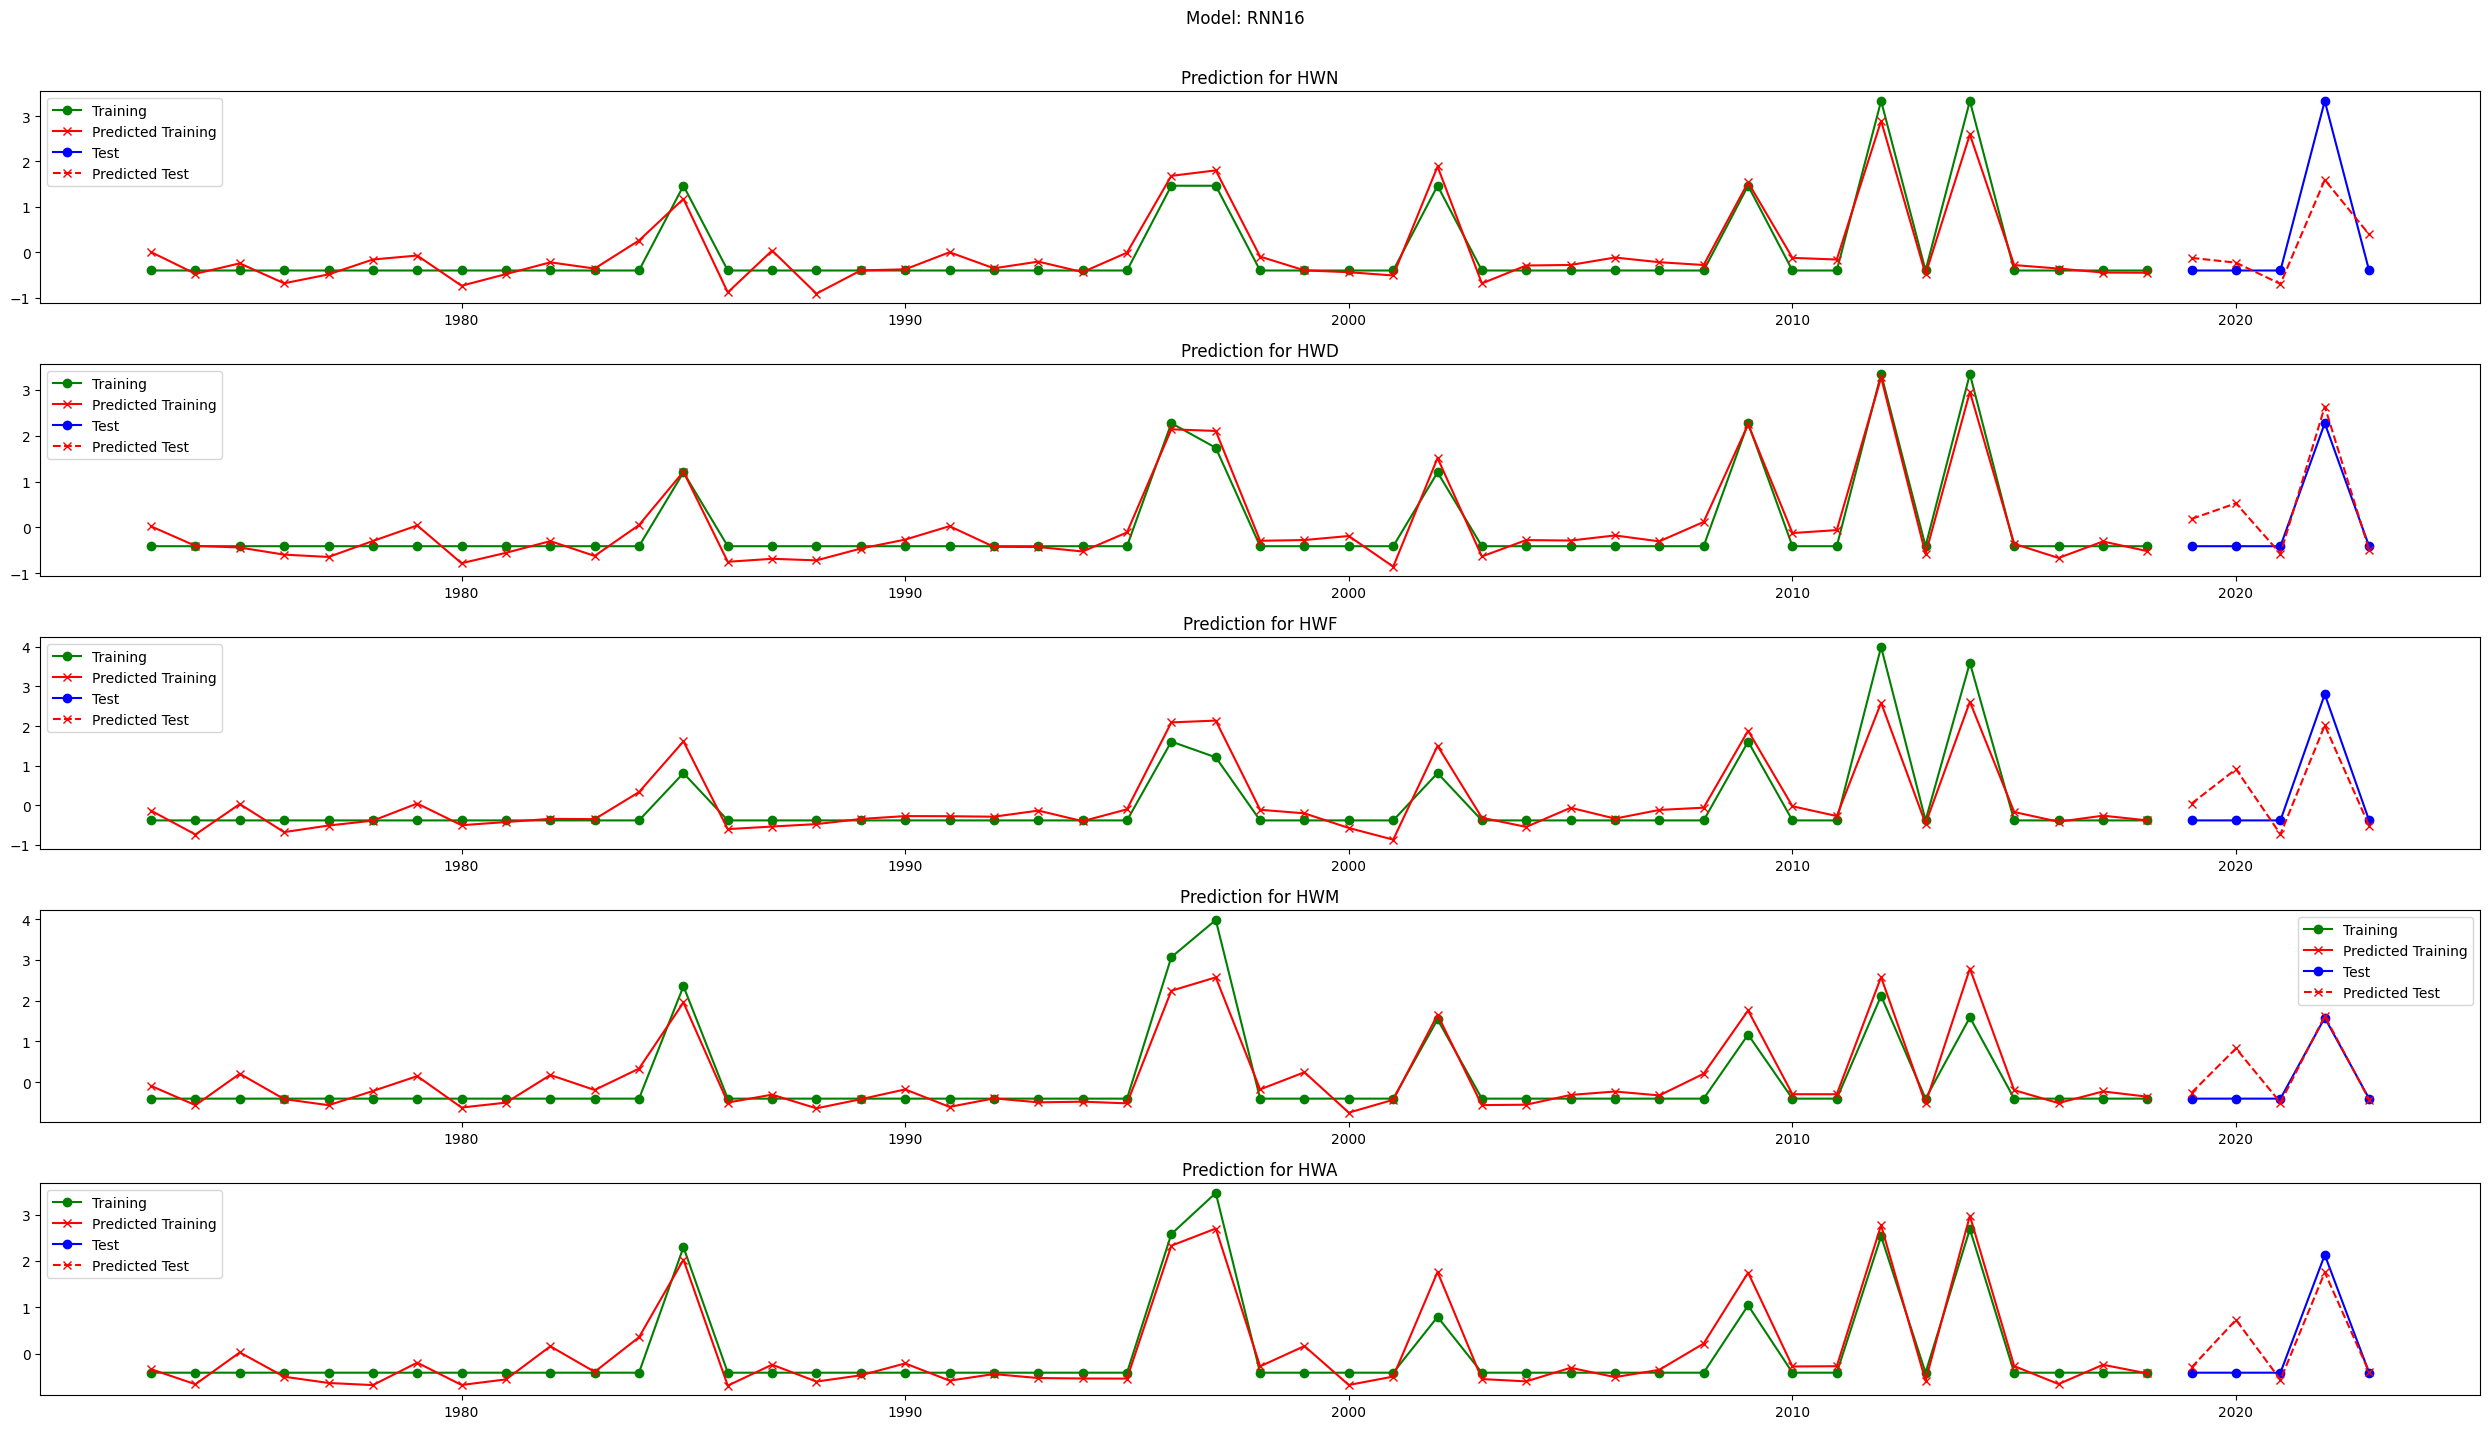

In [48]:
loss_fn = SERA(bounds=bounds,T=100)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)